<a href="https://colab.research.google.com/github/mabench-tuc/LoRA-of-LLMs/blob/main/LoRA_Gpt_2_NL_to_Code_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup Installation Process

In [ ]:
#!pip install git+https://github.com/microsoft/LoRA
!pip install -qU bitsandbytes datasets accelerate loralib transformers peft trl
#!pip install -U datasets
!pip install -U sacrebleu evaluate rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 57.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0

In [ ]:
import torch
torch.cuda.is_available()
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, AutoModelForSeq2SeqLM, TrainingArguments
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoModelForSequenceClassification
from datasets import load_dataset
import bitsandbytes as bnb

## Model's loading
Here we load the model with its weights and the tokenizer

## Load the GPT-2 Large model

In [ ]:
# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the GPT-2 Large model and tokenizer
print("Loading gpt2-large model...")
gpt2_large_model = AutoModelForCausalLM.from_pretrained("gpt2-large").to(device)

gpt2_large_tokenizer = AutoTokenizer.from_pretrained("gpt2-large")
print("Successfully loaded gpt2-large model.")


Loading gpt2-large model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Successfully loaded gpt2-large model.


In [ ]:
model=gpt2_large_model
tokenizer= gpt2_large_tokenizer

## Post-processing on the model
### Freezing the original weights
Finally, we need to apply some post-processing on the n-bit model to enable training, let's freeze all our layers, and cast the layer-norm in floatm for stability.

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

###Display Trainable Parameters

This is a function to print out how much LoRA reduces the number of trainable parameters.

In [ ]:
def print_trainable_parameters(model):

    #Prints the number of trainable parameters in the model.

    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Model Architecture

It's important to observe the model's construction so you can ensure you know which modules you should apply LoRA to.

As per the paper, we're going to focus on the attention weights - so keep an eye out for modules like: `q_proj`, `v_proj`, `query_key_value`. This is model dependent - In our case (GPT-2), the target module is `attn.c_attn`

In [ ]:
print(model)
#print_trainable_parameters(gpt2_large_model)

##Parameter Efficient Fine Tuning
###Set up the LoRA Adapter
Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["attn.c_attn"],
    #target_modules=["query_key_value"],
    #target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

## target_modules='v', This represents the value projection layer in the transformer model. The value projection layer transforms input tokens into value vectors,
# which are the actual values that are attended to based on the attention scores computed from query and key vectors.

## target_modules='q',This typically refers to the query projection layer in a transformer-based model. The query projection layer is responsible for transforming
# input tokens into query vectors, which are used to attend to other tokens in the sequence during self-attention mechanism.

#c_attn: This is the convolution layer that computes the query, key, and value projections. The "q_proj" and "v_proj" are part of this layer.

model = get_peft_model(model, config)

###Display trainable parameters

In [ ]:
print_trainable_parameters(model)

trainable params: 737280 || all params: 774767360 || trainable%: 0.09516146885692242


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## Merge the CodeAlpaca and MBPP Datasets

In [ ]:
# File: merge_mbpp_codealpaca_dataset.py

from datasets import load_dataset, Dataset
import random

# Load datasets
mbpp = load_dataset("mbpp")
# Load CodeAlpaca dataset using the correct identifier
codealpaca = load_dataset("sahil2801/CodeAlpaca-20k")

merged_data = []

# Format MBPP: as instruction-tuning format with test cases included
for row in mbpp["train"]:
    # Construct the prompt in the desired format
    prompt = f"### Instruction\n{row['text'].strip()}\n\n### Input\n{row['code'].strip()}\n\n### Test Cases\n{row['test_list']}"
    merged_data.append({
        "instruction": row["text"].strip(),
        "input": row["code"].strip(),
        "output": row["code"].strip(), # Using code as output for MBPP based on context
        "source": "mbpp",
        "text": prompt # Add the formatted prompt to the data
    })

# Format CodeAlpaca
for row in codealpaca["train"]:
    # Construct the prompt in the desired format
    prompt = f"### Instruction\n{row['instruction'].strip()}\n\n### Input\n{row['input'].strip()}\n\n### Response:\n{row['output'].strip()}"
    merged_data.append({
        "instruction": row["instruction"].strip(),
        "input": row["input"].strip(),
        "output": row["output"].strip(),
        "source": "codealpaca",
        "text": prompt # Add the formatted prompt to the data
    })


# Shuffle merged dataset
random.shuffle(merged_data)

# Save as HuggingFace Dataset
merged_dataset = Dataset.from_list(merged_data)
merged_dataset.save_to_disk("merged_mbpp_codealpaca")

print("✅ Merged dataset saved to: merged_mbpp_codealpaca")

README.md:   0%|          | 0.00/147 [00:00<?, ?B/s]

code_alpaca_20k.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20396 [00:00<?, ? examples/s]

✅ Merged dataset saved to: merged_mbpp_codealpaca


In [ ]:
# prompt: tokenize the merged_dataset

# Set the padding token for the tokenizer
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
  return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = merged_dataset.map(tokenize_function, batched=True)
print("✅ Merged dataset tokenized.")

Map:   0%|          | 0/20396 [00:00<?, ? examples/s]

✅ Merged dataset tokenized.


In [ ]:
dataset = merged_dataset

In [ ]:
tokenized_datasets=tokenized_dataset

In [ ]:
# prompt: split the tokenized_datasets into "train", "test" and "vlidation"

# Define split ratios
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

# Split the dataset
train_test_validation_split = tokenized_datasets.train_test_split(test_size=test_ratio + validation_ratio, seed=42)
test_validation_split = train_test_validation_split["test"].train_test_split(test_size=validation_ratio / (test_ratio + validation_ratio), seed=42)

train_dataset = train_test_validation_split["train"]
test_dataset = test_validation_split["train"]
validation_dataset = test_validation_split["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Train dataset size: 16316
Test dataset size: 2040
Validation dataset size: 2040


## Load CodeAlpaca Dataset

In [ ]:
### Code Dataset

from datasets import load_dataset

ds = load_dataset("sahil2801/CodeAlpaca-20k")

README.md:   0%|          | 0.00/147 [00:00<?, ?B/s]

code_alpaca_20k.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

### Dataset Splits

In [ ]:
from datasets import DatasetDict

# Combine into one dataset and shuffle
ds_all = dataset['train'].shuffle(seed=42)

# Split into train (80%), val (10%), test (10%)
ds_split = ds_all.train_test_split(test_size=0.2, seed=42)
ds_temp = ds_split['test'].train_test_split(test_size=0.5, seed=42)
ds_dict = DatasetDict({
    'train': ds_split['train'],
    'validation': ds_temp['train'],
    'test': ds_temp['test']
})

ValueError: Column 'train' doesn't exist.

In [ ]:
tokenizer.pad_token = tokenizer.eos_token  # ensure padding token is set
# Define prompt template
def format_prompt(example):
    prompt = f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Response:\n{example['output']}"
    return {"text": prompt}

# Apply prompt formatting
ds_dict = ds_dict.map(format_prompt)

# Tokenize function
def tokenize_function(examples):
    tokens = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

# Tokenize the dataset
ds_tokenized = ds_dict.map(tokenize_function, batched=True, remove_columns=ds_dict["train"].column_names)

Map:   0%|          | 0/16017 [00:00<?, ? examples/s]

Map:   0%|          | 0/2002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/16017 [00:00<?, ? examples/s]

Map:   0%|          | 0/2002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets=ds_tokenized
tokenized_datasets.keys()

dict_keys(['train', 'validation', 'test'])

In [ ]:
#Extract a small portion of the
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(3000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(700))
small_val_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(700))

NameError: name 'tokenized_datasets' is not defined

##Training Process

In [ ]:
#Import the necessary modules from the transformers library
import transformers
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer

###Train LoRA Adapter

The `Trainer` class contains all the usual hyper-parameters from traditional ML applications!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig.

In [ ]:
#LoRA paper for hyperparameters for GPT-2 Medium
# Training Arguments
training_args = TrainingArguments(
    output_dir="./output_lora_gpt2",  # Directory for saving the model
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    lr_scheduler_type="linear",
    warmup_steps=500,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir="./logs_lora_gpt2",  # Directory for logging
    logging_steps=10,
    save_total_limit=2,  # Keep only 2 model checkpoints
    load_best_model_at_end=True,
    report_to="none",  # Disable reporting to WandB or other loggers
    fp16=True,  # Enable mixed precision training if you have a GPU
)

# Define a custom data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False  # Causal LM does not use Masked Language Modeling (MLM)
)

In [ ]:
# Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    #train_dataset=tokenized_datasets["train"],
    #eval_dataset=tokenized_datasets.get("validation", None),  # Use validation if available
    #tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train the model
trainer.train()

Truncating train dataset:   0%|          | 0/16316 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2040 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,1.124000,0.958562
2,0.961500,0.921996
3,0.827500,0.904081
4,0.991500,0.892089
5,0.845900,0.887627


TrainOutput(global_step=10200, training_loss=0.9918945657973196, metrics={'train_runtime': 3898.2807, 'train_samples_per_second': 20.927, 'train_steps_per_second': 2.617, 'total_flos': 1.777171542048768e+17, 'train_loss': 0.9918945657973196})

In [ ]:
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 1280)
        (wpe): Embedding(1024, 1280)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-35): 36 x GPT2Block(
            (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=3840, nx=1280)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=3840, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
      

### Pushing the Model to the Hub

In [ ]:
HUGGING_FACE_USER_NAME = "mabc-3"
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_name = "gpt-2-LLoRA-NLP2Code"

model.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:907: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/2.96M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mabc-3/gpt-2-LLoRA-NLP2Code-mergedds/commit/713e45495e0545cf04566e95d2c06b74b0bf189d', commit_message='Upload model', commit_description='', oid='713e45495e0545cf04566e95d2c06b74b0bf189d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mabc-3/gpt-2-LLoRA-NLP2Code-mergedds', endpoint='https://huggingface.co', repo_type='model', repo_id='mabc-3/gpt-2-LLoRA-NLP2Code-mergedds'), pr_revision=None, pr_num=None)

### Load Adapters from the Hub

You can also directly load adapters from the Huggingface Hub using the commands below:

In [ ]:
HUGGING_FACE_USER_NAME = "mabc-3"
model_name = "gpt-2-LLoRA-NLP2Code"

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = f"{HUGGING_FACE_USER_NAME}/{model_name}"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Load the Lora model
lora_model = PeftModel.from_pretrained(model, peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/2.96M [00:00<?, ?B/s]

In [ ]:
print(lora_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 1280)
        (wpe): Embedding(1024, 1280)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-35): 36 x GPT2Block(
            (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=3840, nx=1280)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=3840, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
      

##GPU Check

In [ ]:
!nvidia-smi

## Inference on Code Tasks

###LoRA Model vs Base Model

In [ ]:
base_model_name = "gpt2-large" ##"gpt2"  # Or use gpt2-large

# Load tokenizer
gpt2_large_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# ✅ STEP 4: Load Full Model (no LoRA)
def load_full_model():
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    model.eval()
    return model

In [ ]:
# ✅ Shared settings
#prompt = "Write a Python function to check if a number is prime"
#prompt ="Find the product of all digits in a string, ignoring non-digit characters."
#prompt="Return a list of all substrings of length 3 that are palindromes in the given string."
prompt= "write a function in python to check if a number is a power of two without using loops or recursion."
#prompt= "Sort a list of tuples by the second element in descending order, then by the first element ascending if tie. data = [(1, 3), (2, 3), (3, 2), (4, 4)"
#prompt= "Write a Python function that takes a list of integers and returns the list sorted in descending order."
#prompt= "Write a Python function that returns the factorial of a number using recursion."

max_new_tokens = 250

import time


# ✅ STEP 6: Benchmarking Function
def benchmark_model(model, tokenizer, label="Model"):
    # Ensure padding token is set for the tokenizer
    tokenizer.pad_token = tokenizer.eos_token
    inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)

    # Warm-up
    _ = model.generate(**inputs, max_new_tokens=10)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    start = time.time()
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
    end = time.time()

    latency = end - start
    peak_mem = torch.cuda.max_memory_allocated() / 1024**2
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"\n📌 {label} Result:")
    print("Generated Output:\n", decoded)
    print(f"⏱ Latency: {latency:.3f} seconds")
    print(f"💾 Peak GPU Memory: {peak_mem:.2f} MB")
    return latency, peak_mem


# ✅ STEP 7: Run Comparison
full_model = load_full_model() #change this to BM
lora_model = model ##change this to gpt-2 lora

print("🧪 Benchmarking FULL Model...")
latency_full, mem_full = benchmark_model(full_model, gpt2_large_tokenizer, label="Full GPT-2")

print("\n🧪 Benchmarking LoRA Model...")
latency_lora, mem_lora = benchmark_model(lora_model, tokenizer, label="LoRA GPT-2")

# ✅ STEP 8: Summary Comparison
print("\n📊 COMPARISON SUMMARY")
print(f"Latency: Full = {latency_full:.3f}s | LoRA = {latency_lora:.3f}s")
print(f"Memory:  Full = {mem_full:.2f} MB | LoRA = {mem_lora:.2f} MB")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🧪 Benchmarking FULL Model...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



📌 Full GPT-2 Result:
Generated Output:
 write a function in python to check if a number is a power of two without using loops or recursion.

The function is called power_of_two_checker.py and it is written in python.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function checks if a number is a power of two without using loops or recursion.

The function che

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



📌 LoRA GPT-2 Result:
Generated Output:
 write a function in python to check if a number is a power of two without using loops or recursion.

# Function to check if a number is a power of two without using loops or recursion
def is_power_of_two(num):
    if num % 2 == 0:
        return True
    else:
        return False

# Function to check if a number is a power of two without using loops or recursion
def is_power_of_two_without_loops(num):
    if num % 2 == 0:
        return True
    else:
        return False

# Function to check if a number is a power of two without using loops or recursion
def is_power_of_two_without_recursion(num):
    if num % 2 == 0:
        return True
    else:
        return False

# Function to check if a number is a power of two without using loops or recursion
def is_power_of_two_without_lo
⏱ Latency: 8.297 seconds
💾 Peak GPU Memory: 4632.10 MB

📊 COMPARISON SUMMARY
Latency: Full = 7.036s | LoRA = 8.297s
Memory:  Full = 6039.40 MB | LoRA = 4632.10 MB


### Python Programming Prompts

Practical coding prompts designed to illustrate and assess the fundamental programming capabilities of the fine-tuned LLM.

In [ ]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

print(factorial(5))

120


In [ ]:
factorial(5)

120

In [ ]:
def sort_list(numbers):
    return sorted(numbers)

numbers= [13, 2, 33, 43, 15]
print(sort_list(numbers))

[2, 13, 15, 33, 43]


In [ ]:
def is_power_of_two_without_loops(num):
    if num % 2 == 0:
        return True
    else:
        return False

In [ ]:
def is_power_of_two(num):
    if num % 2 == 0:
        return True
    else:
        return False

In [ ]:
print(is_power_of_two_without_loops(16))
print(is_power_of_two_without_loops(18))

True
True


##Evaluation of the Model

###Evaluation on HumanEval Benchmark

This evaluation framework tests the fine-tuned GPT-2 model on HumanEval by generating code completions, executing them safely, and measuring correctness through Pass@k scores.

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.5380857586860657, 'eval_runtime': 91.8694, 'eval_samples_per_second': 10.885, 'eval_steps_per_second': 1.361, 'epoch': 5.0}


In [ ]:
# File: evaluate_lora_gpt2_humaneval.py

import os
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset
from accelerate import init_empty_weights, infer_auto_device_map
from peft import PeftModel
from tqdm import tqdm

# Config
#MODEL_PATH = "path/to/your/lora/fine-tuned/gpt2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_NEW_TOKENS = 170   #128
NUM_SAMPLES = 5
GENERATION_ARGS = dict(do_sample=True, temperature=0.8, max_new_tokens=MAX_NEW_TOKENS, num_return_sequences=NUM_SAMPLES)

# Load tokenizer and model
#tokenizer = GPT2Tokenizer.from_pretrained(MODEL_PATH)
#model = GPT2LMHeadModel.from_pretrained(MODEL_PATH, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
model = lora_model
model.eval()
model.to(DEVICE)

# Load HumanEval dataset
dataset = load_dataset("openai_humaneval")

def evaluate_sample_k(prompt: str) -> list:
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model.generate(**inputs, **GENERATION_ARGS)
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return [out[len(prompt):] for out in decoded_outputs]

def main():
    passed = 0
    total = 0

    print("\n==================== Evaluation Start ====================\n")

    for idx, item in enumerate(tqdm(dataset["test"], desc="Evaluating")):
        prompt = item["prompt"]
        entry_point = item["entry_point"]
        canonical_solution = item["canonical_solution"]

        completions = evaluate_sample_k(prompt)
        test_passed = False

        for code in completions:
            try:
                local_env = {}
                exec(prompt + code, local_env)
                generated_func = local_env[entry_point]

                reference_env = {}
                exec(prompt + canonical_solution, reference_env)
                reference_func = reference_env[entry_point]

                match_all = True
                for inp in item["test"]:
                    if eval(inp, {}, {entry_point: generated_func}) != eval(inp, {}, {entry_point: reference_func}):
                        match_all = False
                        break

                if match_all:
                    test_passed = True
                    break

            except Exception:
                continue

        status = "✅ PASS" if test_passed else "❌ FAIL"
        print(f"[{idx+1:03}] {entry_point:<30} | {status}")
        print("→ Generated: ", completions[0].strip().splitlines()[0][:120])
        print("→ Reference: ", canonical_solution.strip().splitlines()[0][:120])
        print("------------------------------------------------------------")

        passed += int(test_passed)
        total += 1

    print("\n==================== Evaluation Summary ====================")
    print(f"Total Passed: {passed} / {total}")
    if total > 0:
        print(f"Pass@{NUM_SAMPLES} Score: {passed / total:.2%}")
    else:
        print("Pass@k Score: N/A (No samples evaluated)")
    print("===========================================================\n")

if __name__ == "__main__":
    main()

README.md: 0.00B [00:00, ?B/s]

openai_humaneval/test-00000-of-00001.par(…):   0%|          | 0.00/83.9k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/164 [00:00<?, ? examples/s]


==================== Evaluation Start ====================



Evaluating:   1%|          | 1/164 [00:07<20:31,  7.56s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[001] has_close_elements             | ❌ FAIL
→ Generated:  for i in range(len(numbers)):
→ Reference:  for idx, elem in enumerate(numbers):
------------------------------------------------------------


Evaluating:   1%|          | 2/164 [00:13<18:20,  6.79s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[002] separate_paren_groups          | ❌ FAIL
→ Generated:  return List(separate_paren_groups(paren_string))
→ Reference:  result = []
------------------------------------------------------------


Evaluating:   2%|▏         | 3/164 [00:19<17:20,  6.46s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[003] truncate_number                | ❌ FAIL
→ Generated:  return float(decimal_part(number))
→ Reference:  return number % 1.0
------------------------------------------------------------


Evaluating:   2%|▏         | 4/164 [00:26<16:57,  6.36s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[004] below_zero                     | ❌ FAIL
→ Generated:  return operations[-1]
→ Reference:  balance = 0
------------------------------------------------------------


Evaluating:   3%|▎         | 5/164 [00:32<16:37,  6.27s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[005] mean_absolute_deviation        | ❌ FAIL
→ Generated:  """
→ Reference:  mean = sum(numbers) / len(numbers)
------------------------------------------------------------


Evaluating:   4%|▎         | 6/164 [00:38<16:19,  6.20s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[006] intersperse                    | ❌ FAIL
→ Generated:  """ Test a function that intersperse a list of numbers and delimeter. 
→ Reference:  if not numbers:
------------------------------------------------------------


Evaluating:   4%|▍         | 7/164 [00:44<16:04,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[007] parse_nested_parens            | ❌ FAIL
→ Generated:  return List(first_level(parse_nested_parens(paren_string)))
→ Reference:  def parse_paren_group(s):
------------------------------------------------------------


Evaluating:   5%|▍         | 8/164 [00:50<15:55,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[008] filter_by_substring            | ❌ FAIL
→ Generated:  return List(filter_by_substring(strings, substring))
→ Reference:  return [x for x in strings if substring in x]
------------------------------------------------------------


Evaluating:   5%|▌         | 9/164 [00:56<15:52,  6.14s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[009] sum_product                    | ❌ FAIL
→ Generated:  if len(numbers) == 0:
→ Reference:  sum_value = 0
------------------------------------------------------------


Evaluating:   6%|▌         | 10/164 [01:02<15:40,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[010] rolling_max                    | ❌ FAIL
→ Generated:  for num in numbers:
→ Reference:  running_max = None
------------------------------------------------------------


Evaluating:   7%|▋         | 11/164 [01:08<15:35,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[011] make_palindrome                | ❌ FAIL
→ Generated:  # Find the longest postfix of given string that is a palindrome
→ Reference:  if not string:
------------------------------------------------------------


Evaluating:   7%|▋         | 12/164 [01:14<15:21,  6.06s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[012] string_xor                     | ❌ FAIL
→ Generated:  return a + b
→ Reference:  def xor(i, j):
------------------------------------------------------------


Evaluating:   8%|▊         | 13/164 [01:20<15:19,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[013] longest                        | ❌ FAIL
→ Generated:  return list(longest(list(strings)), None)
→ Reference:  if not strings:
------------------------------------------------------------


Evaluating:   9%|▊         | 14/164 [01:26<15:12,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.6
1.6666666666666667
[014] greatest_common_divisor        | ❌ FAIL
→ Generated:  """Return a greatest common divisor of two integers a and b
→ Reference:  while b:
------------------------------------------------------------


Evaluating:   9%|▉         | 15/164 [01:32<15:05,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[015] all_prefixes                   | ❌ FAIL
→ Generated:  return [str for str in string if len(str) >= 1]
→ Reference:  result = []
------------------------------------------------------------


Evaluating:  10%|▉         | 16/164 [01:38<14:55,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[016] string_sequence                | ❌ FAIL
→ Generated:  return string(n).join(string.ascii_letters)
→ Reference:  return ' '.join([str(x) for x in range(n + 1)])
------------------------------------------------------------


Evaluating:  10%|█         | 17/164 [01:44<14:46,  6.03s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[017] count_distinct_characters      | ❌ FAIL
→ Generated:  """
→ Reference:  return len(set(string.lower()))
------------------------------------------------------------


Evaluating:  11%|█         | 18/164 [01:51<14:46,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[018] parse_music                    | ❌ FAIL
→ Generated:  return List(music_string[-1:])
→ Reference:  note_map = {'o': 4, 'o|': 2, '.|': 1}
------------------------------------------------------------


Evaluating:  12%|█▏        | 19/164 [01:57<14:38,  6.06s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[019] how_many_times                 | ❌ FAIL
→ Generated:  return len(string) - substring
→ Reference:  times = 0
------------------------------------------------------------


Evaluating:  12%|█▏        | 20/164 [02:03<14:31,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[020] sort_numbers                   | ❌ FAIL
→ Generated:  return "";
→ Reference:  value_map = {
------------------------------------------------------------


Evaluating:  13%|█▎        | 21/164 [02:09<14:28,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[021] find_closest_elements          | ❌ FAIL
→ Generated:  return Tuple(numbers, find_closest_elements(numbers[0]) for _ in range(numbers.length))
→ Reference:  closest_pair = None
------------------------------------------------------------


Evaluating:  13%|█▎        | 22/164 [02:15<14:23,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[022] rescale_to_unit                | ❌ FAIL
→ Generated:  return List[float(numbers[::-1]))
→ Reference:  min_number = min(numbers)
------------------------------------------------------------


Evaluating:  14%|█▍        | 23/164 [02:21<14:15,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[023] filter_integers                | ❌ FAIL
→ Generated:  for key, value in values.items():
→ Reference:  return [x for x in values if isinstance(x, int)]
------------------------------------------------------------


Evaluating:  15%|█▍        | 24/164 [02:27<14:08,  6.06s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3
[024] strlen                         | ❌ FAIL
→ Generated:  length = len(string)
→ Reference:  return len(string)
------------------------------------------------------------


Evaluating:  15%|█▌        | 25/164 [02:33<14:01,  6.06s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[025] largest_divisor                | ❌ FAIL
→ Generated:  return largest_divisor(n - 2)
→ Reference:  for i in reversed(range(n)):
------------------------------------------------------------


Evaluating:  16%|█▌        | 26/164 [02:39<13:55,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[026] factorize                      | ❌ FAIL
→ Generated:  return List(max(n, min(n)+1))
→ Reference:  import math
------------------------------------------------------------


Evaluating:  16%|█▋        | 27/164 [02:45<13:49,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[027] remove_duplicates              | ❌ FAIL
→ Generated:  return List(numbers)
→ Reference:  import collections
------------------------------------------------------------


Evaluating:  17%|█▋        | 28/164 [02:51<13:42,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


H
e
l
l
o
o
w
H
e
l
l
o
[028] flip_case                      | ❌ FAIL
→ Generated:  return string[::-1]
→ Reference:  return string.swapcase()
------------------------------------------------------------


Evaluating:  18%|█▊        | 29/164 [02:57<13:36,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[029] concatenate                    | ❌ FAIL
→ Generated:  return concat(sorted(strings))
→ Reference:  return ''.join(strings)
------------------------------------------------------------


Evaluating:  18%|█▊        | 30/164 [03:03<13:31,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[030] filter_by_prefix               | ❌ FAIL
→ Generated:  return List(filter_by_prefix(strings, prefix))
→ Reference:  return [x for x in strings if x.startswith(prefix)]
------------------------------------------------------------


Evaluating:  19%|█▉        | 31/164 [03:09<13:24,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[031] get_positive                   | ❌ FAIL
→ Generated:  return list(l[0])
→ Reference:  return [e for e in l if e > 0]
------------------------------------------------------------


Evaluating:  20%|█▉        | 32/164 [03:15<13:18,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[032] is_prime                       | ❌ FAIL
→ Generated:  if n < 1:
→ Reference:  if n < 2:
------------------------------------------------------------


Evaluating:  20%|██        | 33/164 [03:22<13:21,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[033] find_zero                      | ❌ FAIL
→ Generated:  # If the xs element is negative
→ Reference:  begin, end = -1., 1.
------------------------------------------------------------


Evaluating:  21%|██        | 34/164 [03:28<13:14,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[034] sort_third                     | ❌ FAIL
→ Generated:  return sorted(l)
→ Reference:  l = list(l)
------------------------------------------------------------


Evaluating:  21%|██▏       | 35/164 [03:34<13:07,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[035] unique                         | ❌ FAIL
→ Generated:  return l[::-1]
→ Reference:  return sorted(list(set(l)))
------------------------------------------------------------


Evaluating:  22%|██▏       | 36/164 [03:40<12:59,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[036] max_element                    | ❌ FAIL
→ Generated:  max_element(l) # returns 3
→ Reference:  m = l[0]
------------------------------------------------------------


Evaluating:  23%|██▎       | 37/164 [03:46<12:51,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[037] fizz_buzz                      | ❌ FAIL
→ Generated:  if n == 1:
→ Reference:  ns = []
------------------------------------------------------------


Evaluating:  23%|██▎       | 38/164 [03:52<12:45,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[038] sort_even                      | ❌ FAIL
→ Generated:  return sort_even(l)[0:len(l) - 1]
→ Reference:  evens = l[::2]
------------------------------------------------------------


Evaluating:  24%|██▍       | 39/164 [03:58<12:42,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[039] decode_cyclic                  | ❌ FAIL
→ Generated:  for c in s:
→ Reference:  return encode_cyclic(encode_cyclic(s))
------------------------------------------------------------


Evaluating:  24%|██▍       | 40/164 [04:04<12:36,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[040] prime_fib                      | ❌ FAIL
→ Generated:  result = []
→ Reference:  import math
------------------------------------------------------------


Evaluating:  25%|██▌       | 41/164 [04:10<12:32,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[041] triples_sum_to_zero            | ❌ FAIL
→ Generated:  return triples_sum_to_zero(l[::-1])
→ Reference:  for i in range(len(l)):
------------------------------------------------------------


Evaluating:  26%|██▌       | 42/164 [04:17<12:27,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[042] car_race_collision             | ❌ FAIL
→ Generated:  """
→ Reference:  return n**2
------------------------------------------------------------


Evaluating:  26%|██▌       | 43/164 [04:23<12:17,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 123]
[043] incr_list                      | ❌ FAIL
→ Generated:  for elem in l:
→ Reference:  return [(e + 1) for e in l]
------------------------------------------------------------


Evaluating:  27%|██▋       | 44/164 [04:29<12:12,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[044] pairs_sum_to_zero              | ❌ FAIL
→ Generated:  return pair_sum_to_zero(l) == True
→ Reference:  for i, l1 in enumerate(l):
------------------------------------------------------------


Evaluating:  27%|██▋       | 45/164 [04:35<12:02,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[045] change_base                    | ❌ FAIL
→ Generated:  """
→ Reference:  ret = ""
------------------------------------------------------------


Evaluating:  28%|██▊       | 46/164 [04:41<11:54,  6.05s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


27000000
[046] triangle_area                  | ❌ FAIL
→ Generated:  return (a * h)*h
→ Reference:  return a * h / 2.0
------------------------------------------------------------


Evaluating:  29%|██▊       | 47/164 [04:47<11:53,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[047] fib4                           | ❌ FAIL
→ Generated:  n = n + 1
→ Reference:  results = [0, 0, 2, 0]
------------------------------------------------------------


Evaluating:  29%|██▉       | 48/164 [04:53<11:46,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[048] median                         | ❌ FAIL
→ Generated:  return median(l)
→ Reference:  l = sorted(l)
------------------------------------------------------------


Evaluating:  30%|██▉       | 49/164 [04:59<11:38,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[049] is_palindrome                  | ❌ FAIL
→ Generated:  # check if string is a palindrome
→ Reference:  for i in range(len(text)):
------------------------------------------------------------


Evaluating:  30%|███       | 50/164 [05:05<11:34,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[050] modp                           | ❌ FAIL
→ Generated:  return p * n
→ Reference:  ret = 1
------------------------------------------------------------


Evaluating:  31%|███       | 51/164 [05:11<11:28,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[051] decode_shift                   | ❌ FAIL
→ Generated:  encoded_s = ""
→ Reference:  return "".join([chr(((ord(ch) - 5 - ord("a")) % 26) + ord("a")) for ch in s])
------------------------------------------------------------


Evaluating:  32%|███▏      | 52/164 [05:17<11:23,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[052] remove_vowels                  | ❌ FAIL
→ Generated:  return text
→ Reference:  return "".join([s for s in text if s.lower() not in ["a", "e", "i", "o", "u"]])
------------------------------------------------------------


Evaluating:  32%|███▏      | 53/164 [05:23<11:16,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[053] below_threshold                | ❌ FAIL
→ Generated:  if t < 1:
→ Reference:  for e in l:
------------------------------------------------------------


Evaluating:  33%|███▎      | 54/164 [05:29<11:07,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5
[054] add                            | ❌ FAIL
→ Generated:  return x + y
→ Reference:  return x + y
------------------------------------------------------------


Evaluating:  34%|███▎      | 55/164 [05:36<11:05,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[055] same_chars                     | ❌ FAIL
→ Generated:  s0 = s0.lower()
→ Reference:  return set(s0) == set(s1)
------------------------------------------------------------


Evaluating:  34%|███▍      | 56/164 [05:42<10:57,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[056] fib                            | ❌ FAIL
→ Generated:  n_fibs = [fib(n) for f in n_fibs]
→ Reference:  if n == 0:
------------------------------------------------------------


Evaluating:  35%|███▍      | 57/164 [05:48<10:54,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[057] correct_bracketing             | ❌ FAIL
→ Generated:  if not brackets:
→ Reference:  depth = 0
------------------------------------------------------------


Evaluating:  35%|███▌      | 58/164 [05:54<10:45,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[058] monotonic                      | ❌ FAIL
→ Generated:  return ((l % n) == 0)
→ Reference:  if l == sorted(l) or l == sorted(l, reverse=True):
------------------------------------------------------------


Evaluating:  36%|███▌      | 59/164 [06:00<10:40,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[059] common                         | ❌ FAIL
→ Generated:  for key in l1:
→ Reference:  ret = set()
------------------------------------------------------------


Evaluating:  37%|███▋      | 60/164 [06:06<10:32,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[060] largest_prime_factor           | ❌ FAIL
→ Generated:  if n == 1:
→ Reference:  def is_prime(k):
------------------------------------------------------------


Evaluating:  37%|███▋      | 61/164 [06:12<10:26,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[061] sum_to_n                       | ❌ FAIL
→ Generated:  return sum_to_n(n)
→ Reference:  return sum(range(n + 1))
------------------------------------------------------------


Evaluating:  38%|███▊      | 62/164 [06:18<10:19,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[062] correct_bracketing             | ❌ FAIL
→ Generated:  return bracketed_bracketing(brackets)
→ Reference:  depth = 0
------------------------------------------------------------


Evaluating:  38%|███▊      | 63/164 [06:24<10:13,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[063] derivative                     | ❌ FAIL
→ Generated:  return xs[0] + xs[1] * x + xs[2] * x^2 + ....
→ Reference:  return [(i * x) for i, x in enumerate(xs)][1:]
------------------------------------------------------------


Evaluating:  39%|███▉      | 64/164 [06:30<10:08,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[064] fibfib                         | ❌ FAIL
→ Generated:  def fib_count(fib_seq):
→ Reference:  if n == 0:
------------------------------------------------------------


Evaluating:  40%|███▉      | 65/164 [06:36<10:02,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Vowels count: 5
[065] vowels_count                   | ❌ FAIL
→ Generated:  FIX = """
→ Reference:  vowels = "aeiouAEIOU"
------------------------------------------------------------


Evaluating:  40%|████      | 66/164 [06:42<09:55,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[066] circular_shift                 | ❌ FAIL
→ Generated:  return ''.join(shift)
→ Reference:  s = str(x)
------------------------------------------------------------


Evaluating:  41%|████      | 67/164 [06:49<09:49,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[067] digitSum                       | ❌ FAIL
→ Generated:  result = ""
→ Reference:  if s == "": return 0
------------------------------------------------------------


Evaluating:  41%|████▏     | 68/164 [06:55<09:46,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[068] fruit_distribution             | ❌ FAIL
→ Generated:  s = s + ""
→ Reference:  lis = list()
------------------------------------------------------------


Evaluating:  42%|████▏     | 69/164 [07:01<09:50,  6.22s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[069] pluck                          | ❌ FAIL
→ Generated:  return [ smalest_value, its index ]
→ Reference:  if(len(arr) == 0): return []
------------------------------------------------------------


Evaluating:  43%|████▎     | 70/164 [07:07<09:43,  6.21s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[070] search                         | ❌ FAIL
→ Generated:  lst = [5, 4, 5, 4, 4, 4, 4]
→ Reference:  frq = [0] * (max(lst) + 1)
------------------------------------------------------------


Evaluating:  43%|████▎     | 71/164 [07:14<09:37,  6.21s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[071] strange_sort_list              | ❌ FAIL
→ Generated:  result = list(strange_sort_list(lst))
→ Reference:  res, switch = [], True
------------------------------------------------------------


Evaluating:  44%|████▍     | 72/164 [07:20<09:28,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8.333333333333334
5.0
8.333333333333334
[072] triangle_area                  | ❌ FAIL
→ Generated:  def triangle_area(a, b, c):
→ Reference:  if a + b <= c or a + c <= b or b + c <= a:
------------------------------------------------------------


Evaluating:  45%|████▍     | 73/164 [07:26<09:23,  6.20s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[073] will_it_fly                    | ❌ FAIL
→ Generated:  """
→ Reference:  if sum(q) > w:
------------------------------------------------------------


Evaluating:  45%|████▌     | 74/164 [07:32<09:14,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[074] smallest_change                | ❌ FAIL
→ Generated:  return arr[:1]
→ Reference:  ans = 0
------------------------------------------------------------


Evaluating:  46%|████▌     | 75/164 [07:38<09:07,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[075] total_match                    | ❌ FAIL
→ Generated:  total_match([], []) ➞ ['4']
→ Reference:  l1 = 0
------------------------------------------------------------


Evaluating:  46%|████▋     | 76/164 [07:44<08:58,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[076] is_multiply_prime              | ❌ FAIL
→ Generated:  if (a <= 100):
→ Reference:  def is_prime(n):
------------------------------------------------------------


Evaluating:  47%|████▋     | 77/164 [07:50<08:52,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[077] is_simple_power                | ❌ FAIL
→ Generated:  if not n:
→ Reference:  if (n == 1): 
------------------------------------------------------------


Evaluating:  48%|████▊     | 78/164 [07:56<08:47,  6.13s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[078] iscube                         | ❌ FAIL
→ Generated:  def is_convoluted(a):
→ Reference:  a = abs(a)
------------------------------------------------------------


Evaluating:  48%|████▊     | 79/164 [08:03<08:47,  6.20s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[079] hex_key                        | ❌ FAIL
→ Generated:  if num in [1, 2, 3, 4, 5, 6, 7, 8, 9, A, B, C, D, E, F]:
→ Reference:  primes = ('2', '3', '5', '7', 'B', 'D')
------------------------------------------------------------


Evaluating:  49%|████▉     | 80/164 [08:09<08:40,  6.19s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[080] decimal_to_binary              | ❌ FAIL
→ Generated:  return '%d' % decimal
→ Reference:  return "db" + bin(decimal)[2:] + "db"
------------------------------------------------------------


Evaluating:  49%|████▉     | 81/164 [08:15<08:32,  6.17s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[081] is_happy                       | ❌ FAIL
→ Generated:  return is_happy(s.replace(' ', '-'))
→ Reference:  if len(s) < 3:
------------------------------------------------------------


Evaluating:  50%|█████     | 82/164 [08:22<08:38,  6.32s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[082] numerical_letter_grade         | ❌ FAIL
→ Generated:  letter_grades = [grade for grade in grades.items() if grade != 'A' and grade != 'B' and grade != 'C']
→ Reference:  letter_grade = []
------------------------------------------------------------


Evaluating:  51%|█████     | 83/164 [08:28<08:25,  6.25s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


False
[083] prime_length                   | ❌ FAIL
→ Generated:  def prime_length(string):
→ Reference:  l = len(string)
------------------------------------------------------------


Evaluating:  51%|█████     | 84/164 [08:34<08:14,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


99
[084] starts_one_ends                | ❌ FAIL
→ Generated:  count = 0
→ Reference:  if n == 1: return 1
------------------------------------------------------------


Evaluating:  52%|█████▏    | 85/164 [08:40<08:08,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[085] solve                          | ❌ FAIL
→ Generated:  for i in range(N):
→ Reference:  return bin(sum(int(i) for i in str(N)))[2:]
------------------------------------------------------------


Evaluating:  52%|█████▏    | 86/164 [08:46<07:59,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[086] add                            | ❌ FAIL
→ Generated:  return lst[::-1] + lst[::-2]
→ Reference:  return sum([lst[i] for i in range(1, len(lst), 2) if lst[i]%2 == 0])
------------------------------------------------------------


Evaluating:  53%|█████▎    | 87/164 [08:52<07:52,  6.14s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[087] anti_shuffle                   | ❌ FAIL
→ Generated:  """
→ Reference:  return ' '.join([''.join(sorted(list(i))) for i in s.split(' ')])
------------------------------------------------------------


Evaluating:  54%|█████▎    | 88/164 [08:59<07:49,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[088] get_row                        | ❌ FAIL
→ Generated:  lst = [1, 2, 3, 4, 5, 6]
→ Reference:  coords = [(i, j) for i in range(len(lst)) for j in range(len(lst[i])) if lst[i][j] == x]
------------------------------------------------------------


Evaluating:  54%|█████▍    | 89/164 [09:05<07:43,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[089] sort_array                     | ❌ FAIL
→ Generated:  array = sorted(array)
→ Reference:  return [] if len(array) == 0 else sorted(array, reverse= (array[0]+array[-1]) % 2 == 0)
------------------------------------------------------------


Evaluating:  55%|█████▍    | 90/164 [09:11<07:35,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[090] encrypt                        | ❌ FAIL
→ Generated:  s = s.replace(random.choice(alphabet) for i in range(2, len(s)+1))
→ Reference:  d = 'abcdefghijklmnopqrstuvwxyz'
------------------------------------------------------------


Evaluating:  55%|█████▌    | 91/164 [09:17<07:26,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[091] next_smallest                  | ❌ FAIL
→ Generated:  return next_smallest([2, 3, 4, 5])
→ Reference:  lst = sorted(set(lst))
------------------------------------------------------------


Evaluating:  56%|█████▌    | 92/164 [09:23<07:20,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[092] is_bored                       | ❌ FAIL
→ Generated:  S = "The sky is blue. The sun is shining. I love this weather"
→ Reference:  import re
------------------------------------------------------------


Evaluating:  57%|█████▋    | 93/164 [09:29<07:13,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[093] any_int                        | ❌ FAIL
→ Generated:  def any_bool(x, y, z):
→ Reference:  if isinstance(x,int) and isinstance(y,int) and isinstance(z,int):
------------------------------------------------------------


Evaluating:  57%|█████▋    | 94/164 [09:35<07:06,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[094] encode                         | ❌ FAIL
→ Generated:  return ' '.join(alphabet)
→ Reference:  vowels = "aeiouAEIOU"
------------------------------------------------------------


Evaluating:  58%|█████▊    | 95/164 [09:41<07:03,  6.14s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Input is not a list
[095] skjkasdkd                      | ❌ FAIL
→ Generated:  lst.append(lst[::-1])
→ Reference:  def isPrime(n):
------------------------------------------------------------


Evaluating:  59%|█████▊    | 96/164 [09:48<06:58,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[096] check_dict_case                | ❌ FAIL
→ Generated:  if len(dict) > 1:
→ Reference:  if len(dict.keys()) == 0:
------------------------------------------------------------


Evaluating:  59%|█████▉    | 97/164 [09:54<06:52,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[097] count_up_to                    | ❌ FAIL
→ Generated:  def max_up_to(n):
→ Reference:  primes = []
------------------------------------------------------------


Evaluating:  60%|█████▉    | 98/164 [10:00<06:44,  6.13s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[098] multiply                       | ❌ FAIL
→ Generated:  """
→ Reference:  return abs(a % 10) * abs(b % 10)
------------------------------------------------------------


Evaluating:  60%|██████    | 99/164 [10:06<06:36,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[099] count_upper                    | ❌ FAIL
→ Generated:  return len(s) + count_upper(s[0])
→ Reference:  count = 0
------------------------------------------------------------


Evaluating:  61%|██████    | 100/164 [10:12<06:30,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[100] closest_integer                | ❌ FAIL
→ Generated:  return closest_integer(value)
→ Reference:  from math import floor, ceil
------------------------------------------------------------


Evaluating:  62%|██████▏   | 101/164 [10:18<06:24,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[101] make_a_pile                    | ❌ FAIL
→ Generated:  while True:
→ Reference:  return [n + 2*i for i in range(n)]
------------------------------------------------------------


Evaluating:  62%|██████▏   | 102/164 [10:24<06:17,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[102] words_string                   | ❌ FAIL
→ Generated:  words = s.split()
→ Reference:  if not s:
------------------------------------------------------------


Evaluating:  63%|██████▎   | 103/164 [10:30<06:10,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[103] choose_num                     | ❌ FAIL
→ Generated:  return choose_num((x, y)**2).int_floor(2)
→ Reference:  if x > y:
------------------------------------------------------------


Evaluating:  63%|██████▎   | 104/164 [10:36<06:05,  6.08s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[104] rounded_avg                    | ❌ FAIL
→ Generated:  return 0.0 if n > m, 0.0 if m > n, -0.0 if n < m / 2.0
→ Reference:  if m < n:
------------------------------------------------------------


Evaluating:  64%|██████▍   | 105/164 [10:42<05:58,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[33, 1422, 1]
[105] unique_digits                  | ❌ FAIL
→ Generated:  return sorted(x, key=lambda x: x[::-1])
→ Reference:  odd_digit_elements = []
------------------------------------------------------------


Evaluating:  65%|██████▍   | 106/164 [10:49<05:55,  6.14s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[106] by_length                      | ❌ FAIL
→ Generated:  arr = [2, 1, 1, 4, 5, 8, 2, 3]
→ Reference:  dic = {
------------------------------------------------------------


Evaluating:  65%|██████▌   | 107/164 [10:55<05:48,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[107] f                              | ❌ FAIL
→ Generated:  n = n
→ Reference:  ret = []
------------------------------------------------------------


Evaluating:  66%|██████▌   | 108/164 [11:01<05:43,  6.14s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[108] even_odd_palindrome            | ❌ FAIL
→ Generated:  if n > 0:
→ Reference:  def is_palindrome(n):
------------------------------------------------------------


Evaluating:  66%|██████▋   | 109/164 [11:07<05:35,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[109] count_nums                     | ❌ FAIL
→ Generated:  return count(arr) / len(arr)
→ Reference:  def digits_sum(n):
------------------------------------------------------------


Evaluating:  67%|██████▋   | 110/164 [11:13<05:33,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[110] move_one_ball                  | ❌ FAIL
→ Generated:  return False
→ Reference:  if len(arr)==0:
------------------------------------------------------------


Evaluating:  68%|██████▊   | 111/164 [11:19<05:26,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[111] exchange                       | ❌ FAIL
→ Generated:  return True if either the input given list elements are even, False if they are not, and if lst1 is not a list of even n
→ Reference:  odd = 0
------------------------------------------------------------


Evaluating:  68%|██████▊   | 112/164 [11:25<05:20,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[112] histogram                      | ❌ FAIL
→ Generated:  for char in test:
→ Reference:  dict1={}
------------------------------------------------------------


Evaluating:  69%|██████▉   | 113/164 [11:32<05:13,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[113] reverse_delete                 | ❌ FAIL
→ Generated:  return [s, c]
→ Reference:  s = ''.join([char for char in s if char not in c])
------------------------------------------------------------


Evaluating:  70%|██████▉   | 114/164 [11:38<05:07,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[114] odd_count                      | ❌ FAIL
→ Generated:  if len(lst) == 0:
→ Reference:  res = []
------------------------------------------------------------


Evaluating:  70%|███████   | 115/164 [11:44<05:00,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[115] minSubArraySum                 | ❌ FAIL
→ Generated:  return minSubArraySum(nums)
→ Reference:  max_sum = 0
------------------------------------------------------------


Evaluating:  71%|███████   | 116/164 [11:50<04:58,  6.22s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[116] max_fill                       | ❌ FAIL
→ Generated:  max_fill = math.floor(capacity/4)
→ Reference:  return sum([math.ceil(sum(arr)/capacity) for arr in grid])
------------------------------------------------------------


Evaluating:  71%|███████▏  | 117/164 [11:56<04:52,  6.22s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[117] sort_array                     | ❌ FAIL
→ Generated:  def __iter__(self):
→ Reference:  return sorted(sorted(arr), key=lambda x: bin(x)[2:].count('1'))
------------------------------------------------------------


Evaluating:  72%|███████▏  | 118/164 [12:03<04:45,  6.20s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[118] select_words                   | ❌ FAIL
→ Generated:  return [s.split(i) for i in range(n)]
→ Reference:  result = []
------------------------------------------------------------


Evaluating:  73%|███████▎  | 119/164 [12:09<04:37,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[119] get_closest_vowel              | ❌ FAIL
→ Generated:  for word in word.split():
→ Reference:  if len(word) < 3:
------------------------------------------------------------


Evaluating:  73%|███████▎  | 120/164 [12:15<04:31,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[120] match_parens                   | ❌ FAIL
→ Generated:  lst = '('
→ Reference:  def check(s):
------------------------------------------------------------


Evaluating:  74%|███████▍  | 121/164 [12:21<04:26,  6.19s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[121] maximum                        | ❌ FAIL
→ Generated:  return sorted(arr, key=k)
→ Reference:  if k == 0:
------------------------------------------------------------


Evaluating:  74%|███████▍  | 122/164 [12:27<04:18,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[122] solution                       | ❌ FAIL
→ Generated:  # Iterate over lst
→ Reference:  return sum([x for idx, x in enumerate(lst) if idx%2==0 and x%2==1])
------------------------------------------------------------


Evaluating:  75%|███████▌  | 123/164 [12:33<04:12,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[123] add_elements                   | ❌ FAIL
→ Generated:  return arr + k
→ Reference:  return sum(elem for elem in arr[:k] if len(str(elem)) <= 2)
------------------------------------------------------------


Evaluating:  76%|███████▌  | 124/164 [12:40<04:06,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[124] get_odd_collatz                | ❌ FAIL
→ Generated:  # The following function creates a sorted list of the odd numbers
→ Reference:  if n%2==0:
------------------------------------------------------------


Evaluating:  76%|███████▌  | 125/164 [12:46<04:01,  6.19s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[125] valid_date                     | ❌ FAIL
→ Generated:  if not date.is_a():
→ Reference:  try:
------------------------------------------------------------


Evaluating:  77%|███████▋  | 126/164 [12:52<03:54,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[126] split_words                    | ❌ FAIL
→ Generated:  def whitespace_in_text(txt, sep):
→ Reference:  if " " in txt:
------------------------------------------------------------


Evaluating:  77%|███████▋  | 127/164 [12:58<03:47,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[127] is_sorted                      | ❌ FAIL
→ Generated:  """This function sorts a list of numbers in ascending order based on the value of the 'sort' attribute.
→ Reference:  count_digit = dict([(i, 0) for i in lst])
------------------------------------------------------------


Evaluating:  78%|███████▊  | 128/164 [13:04<03:43,  6.20s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[128] intersection                   | ❌ FAIL
→ Generated:  """
→ Reference:  def is_prime(num):
------------------------------------------------------------


Evaluating:  79%|███████▊  | 129/164 [13:10<03:36,  6.17s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[129] prod_signs                     | ❌ FAIL
→ Generated:  return (sum(max(arr[0], prod_signs(arr))) for max(arr, prod_signs(arr)))
→ Reference:  if not arr: return None
------------------------------------------------------------


Evaluating:  79%|███████▉  | 130/164 [13:17<03:32,  6.25s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[130] minPath                        | ❌ FAIL
→ Generated:  k = 3
→ Reference:  n = len(grid)
------------------------------------------------------------


Evaluating:  80%|███████▉  | 131/164 [13:23<03:26,  6.25s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[131] tri                            | ❌ FAIL
→ Generated:  n = int(input("Enter a valid number): "))
→ Reference:  if n == 0:
------------------------------------------------------------


Evaluating:  80%|████████  | 132/164 [13:29<03:18,  6.19s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[132] digits                         | ❌ FAIL
→ Generated:  if n % 2 == 0:
→ Reference:  product = 1
------------------------------------------------------------


Evaluating:  81%|████████  | 133/164 [13:35<03:11,  6.17s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[133] is_nested                      | ❌ FAIL
→ Generated:  if is_nested(string):
→ Reference:  opening_bracket_index = []
------------------------------------------------------------


Evaluating:  82%|████████▏ | 134/164 [13:41<03:04,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[134] sum_squares                    | ❌ FAIL
→ Generated:  left = []
→ Reference:  import math
------------------------------------------------------------


Evaluating:  82%|████████▏ | 135/164 [13:48<02:57,  6.13s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[135] check_if_last_char_is_a_letter | ❌ FAIL
→ Generated:  def check_if_last_char_is_alphabetical(txt):
→ Reference:  check = txt.split(' ')[-1]
------------------------------------------------------------


Evaluating:  83%|████████▎ | 136/164 [13:54<02:50,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[136] can_arrange                    | ❌ FAIL
→ Generated:  max_index = len(arr)
→ Reference:  ind=-1
------------------------------------------------------------


Evaluating:  84%|████████▎ | 137/164 [14:00<02:44,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[137] largest_smallest_integers      | ❌ FAIL
→ Generated:  """
→ Reference:  smallest = list(filter(lambda x: x < 0, lst))
------------------------------------------------------------


Evaluating:  84%|████████▍ | 138/164 [14:06<02:39,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[138] compare_one                    | ❌ FAIL
→ Generated:  return (a, b)
→ Reference:  temp_a, temp_b = a, b
------------------------------------------------------------


Evaluating:  85%|████████▍ | 139/164 [14:12<02:32,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[139] is_equal_to_sum_even           | ❌ FAIL
→ Generated:  if n == 0:
→ Reference:  return n%2 == 0 and n >= 8
------------------------------------------------------------


Evaluating:  85%|████████▌ | 140/164 [14:18<02:26,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[140] special_factorial              | ❌ FAIL
→ Generated:  return int(brazilian_factorial(n))
→ Reference:  fact_i = 1
------------------------------------------------------------


Evaluating:  86%|████████▌ | 141/164 [14:24<02:19,  6.07s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example
[141] fix_spaces                     | ❌ FAIL
→ Generated:  return fix_spaces("Example")
→ Reference:  new_text = ""
------------------------------------------------------------


Evaluating:  87%|████████▋ | 142/164 [14:30<02:13,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[142] file_name_check                | ❌ FAIL
→ Generated:  def check_file_name(file_name):
→ Reference:  suf = ['txt', 'exe', 'dll']
------------------------------------------------------------


Evaluating:  87%|████████▋ | 143/164 [14:36<02:08,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[143] sum_squares                    | ❌ FAIL
→ Generated:  def sum_squares(lst):
→ Reference:  result =[]
------------------------------------------------------------


Evaluating:  88%|████████▊ | 144/164 [14:42<02:02,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[144] words_in_sentence              | ❌ FAIL
→ Generated:  """
→ Reference:  new_lst = []
------------------------------------------------------------


Evaluating:  88%|████████▊ | 145/164 [14:48<01:56,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[145] simplify                       | ❌ FAIL
→ Generated:  x = int(input("Enter the x: "))
→ Reference:  a, b = x.split("/")
------------------------------------------------------------


Evaluating:  89%|████████▉ | 146/164 [14:55<01:49,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[146] order_by_points                | ❌ FAIL
→ Generated:  if nums.isdigit():
→ Reference:  def digits_sum(n):
------------------------------------------------------------


Evaluating:  90%|████████▉ | 147/164 [15:01<01:43,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[147] specialFilter                  | ❌ FAIL
→ Generated:  for num in nums:
→ Reference:  count = 0
------------------------------------------------------------


Evaluating:  90%|█████████ | 148/164 [15:07<01:38,  6.14s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[148] get_max_triples                | ❌ FAIL
→ Generated:  """
→ Reference:  A = [i*i - i + 1 for i in range(1,n+1)]
------------------------------------------------------------


Evaluating:  91%|█████████ | 149/164 [15:13<01:32,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


None
None
None
None
None
[149] bf                             | ❌ FAIL
→ Generated:  def zf(planet1, planet2):
→ Reference:  planet_names = ("Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune")
------------------------------------------------------------


Evaluating:  91%|█████████▏| 150/164 [15:19<01:26,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


List of strings with odd lengths is:
[150] sorted_list_sum                | ❌ FAIL
→ Generated:  return sorted_list_sum(lst)
→ Reference:  lst.sort()
------------------------------------------------------------


Evaluating:  92%|█████████▏| 151/164 [15:25<01:19,  6.13s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[151] x_or_y                         | ❌ FAIL
→ Generated:  if n == 0:
→ Reference:  if n == 1:
------------------------------------------------------------


Evaluating:  93%|█████████▎| 152/164 [15:31<01:13,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[152] double_the_difference          | ❌ FAIL
→ Generated:  if len(lst) > 1:
→ Reference:  return sum([i**2 for i in lst if i > 0 and i%2!=0 and "." not in str(i)])
------------------------------------------------------------


Evaluating:  93%|█████████▎| 153/164 [15:38<01:07,  6.14s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[153] compare                        | ❌ FAIL
→ Generated:  result = [0]
→ Reference:  return [abs(x-y) for x,y in zip(game,guess)]
------------------------------------------------------------


Evaluating:  94%|█████████▍| 154/164 [15:44<01:01,  6.19s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[154] Strongest_Extension            | ❌ FAIL
→ Generated:  if len(extensions) == 0 and class_name == 'my_class':
→ Reference:  strong = extensions[0]
------------------------------------------------------------


Evaluating:  95%|█████████▍| 155/164 [15:50<00:55,  6.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[155] cycpattern_check               | ❌ FAIL
→ Generated:  """
→ Reference:  l = len(b)
------------------------------------------------------------


Evaluating:  95%|█████████▌| 156/164 [15:56<00:49,  6.13s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[156] even_odd_count                 | ❌ FAIL
→ Generated:  return [x for x in num for x in even_odd_count()]
→ Reference:  even_count = 0
------------------------------------------------------------


Evaluating:  96%|█████████▌| 157/164 [16:02<00:42,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[157] int_to_mini_roman              | ❌ FAIL
→ Generated:  """
→ Reference:  num = [1, 4, 5, 9, 10, 40, 50, 90,  
------------------------------------------------------------


Evaluating:  96%|█████████▋| 158/164 [16:08<00:36,  6.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[158] right_angle_triangle           | ❌ FAIL
→ Generated:  """
→ Reference:  return a*a == b*b + c*c or b*b == a*a + c*c or c*c == a*a + b*b
------------------------------------------------------------


Evaluating:  97%|█████████▋| 159/164 [16:14<00:30,  6.10s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[159] find_max                       | ❌ FAIL
→ Generated:  return max(words).lower()
→ Reference:  return sorted(words, key = lambda x: (-len(set(x)), x))[0]
------------------------------------------------------------


Evaluating:  98%|█████████▊| 160/164 [16:21<00:24,  6.18s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[160] eat                            | ❌ FAIL
→ Generated:  def calculate_total_remaining_carrots(number, need, remaining):
→ Reference:  if(need <= remaining):
------------------------------------------------------------


Evaluating:  98%|█████████▊| 161/164 [16:27<00:18,  6.17s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[161] do_algebra                     | ❌ FAIL
→ Generated:  operator[0] = [1,2,3]
→ Reference:  expression = str(operand[0])
------------------------------------------------------------


Evaluating:  99%|█████████▉| 162/164 [16:33<00:12,  6.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[162] solve                          | ❌ FAIL
→ Generated:  """
→ Reference:  flg = 0
------------------------------------------------------------


Evaluating:  99%|█████████▉| 163/164 [16:39<00:06,  6.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[163] string_to_md5                  | ❌ FAIL
→ Generated:  return md5(text)
→ Reference:  import hashlib
------------------------------------------------------------


Evaluating: 100%|██████████| 164/164 [16:45<00:00,  6.13s/it]

[164] generate_integers              | ❌ FAIL
→ Generated:  return a + b
→ Reference:  lower = max(2, min(a, b))
------------------------------------------------------------

==================== Evaluation Summary ====================
Total Passed: 0 / 164
Pass@5 Score: 0.00%



### Analysis:
LoRA fine-tuned GPT-2 Large on CodeAlpaca performs well on code-style prompts but fails on the HumanEval dataset.

*   CodeAlpaca focuses on instruction-style completions, mostly docstring-to-code or natural language to code.
*   These prompts are simplified and often lack complex logic, recursion, or rigorous test cases.

*   LoRA fine-tuning adapts your model well to generate syntactically-correct, readable code, especially if prompts resemble your training distribution.

###Failure on HumanEval:
HumanEval is a strict unit-test-driven benchmark. It requires:

*   Full correctness (not just plausible code)
*   Handling edge cases
*   Understanding nuanced logic (e.g., dynamic programming, recursion, math, string parsing)

▶ It fails to learn **deep functional reasoning**, which requires **diverse and structured training signals** — missing from CodeAlpaca.

##Switching between adapters
You can “merge” two LoRA adapters, you apply both updates to the base model:


You can also reload GPT-2 and swap adapters anytime:

In [ ]:
from peft import PeftModel, AutoModelForCausalLM

# Load base GPT-2 again
base_model = AutoModelForCausalLM.from_pretrained("gpt2 Large")

# Load CodeAlpaca LoRA
codealpaca_model = PeftModel.from_pretrained(base_model, "./lora-codealpaca")

# Load MBPP LoRA
mbpp_model = PeftModel.from_pretrained(base_model, "./lora-mbpp")

# Switch between them
mbpp_model.set_adapter("mbpp_adapter")

## Further Fine-Tuning on MBPP Dataset

In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 112.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# 1. Load MBPP dataset
dataset = load_dataset("mbpp")

# 2. Choose tokenizer (GPT-2 in your case)
#tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token

# 3. Preprocessing: join prompt + code solution
def preprocess(batch):
    # You can customize the prompt style here
    text = [
        f"Problem: {p}\nSolution:\n{s}"
        for p, s in zip(batch["text"], batch["code"])
    ]
    return tokenizer(text, truncation=True, padding="max_length", max_length=512)

# 4. Apply preprocessing
tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)

print(tokenized_dataset)

README.md: 0.00B [00:00, ?B/s]

full/train-00000-of-00001.parquet:   0%|          | 0.00/87.2k [00:00<?, ?B/s]

full/test-00000-of-00001.parquet:   0%|          | 0.00/116k [00:00<?, ?B/s]

full/validation-00000-of-00001.parquet:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

full/prompt-00000-of-00001.parquet:   0%|          | 0.00/7.88k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/374 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/90 [00:00<?, ? examples/s]

Generating prompt split:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 374
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 90
    })
    prompt: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 10
    })
})


In [ ]:
# Add labels = input_ids to every split
tokenized_dataset = tokenized_dataset.map(
    lambda batch: {"labels": batch["input_ids"]},
    batched=True
)

# Now you can safely pass train/val datasets
train_dataset = tokenized_dataset["train"]
eval_dataset  = tokenized_dataset["validation"]
test_dataset = tokenized_dataset["test"]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 374
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 90
    })
    prompt: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
})


In [ ]:
# metrics.py
import numpy as np
import evaluate
import Levenshtein
import contextlib
import io

# Load Hugging Face metrics once
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def safe_exec(code, func_name, test_inputs, expected_outputs):
    """Run generated code in restricted env and validate against tests."""
    env = {}
    try:
        with contextlib.redirect_stdout(io.StringIO()):
            exec(code, env)
        func = env.get(func_name, None)
        if func is None:
            return False, 0.0

        passed, total = 0, len(test_inputs)
        for inp, exp in zip(test_inputs, expected_outputs):
            out = func(*inp) if isinstance(inp, tuple) else func(inp)
            if out == exp:
                passed += 1
        return passed == total, passed / total
    except Exception:
        return False, 0.0


def pass_at_k(num_correct, num_samples, k):
    """Compute Pass@k as in HumanEval."""
    if num_samples == 0 or num_correct == 0:
        return 0.0
    return 1.0 - np.prod([
        (1.0 - (num_correct / (num_samples - i)))
        for i in range(min(k, num_samples - num_correct + 1))
    ])


def build_compute_metrics(tokenizer, k=3, mbpp_tests=None):
    """
    Returns a compute_metrics function compatible with Hugging Face Trainer.
    Captures tokenizer + optional MBPP test set.
    """
    def compute_metrics(eval_preds):
        preds, labels = eval_preds

        # ---- Prepare predictions and labels ----
        # If logits, take argmax over vocab
        if preds.ndim == 3:  # (batch, seq_len, vocab_size)
            preds = np.argmax(preds, axis=-1)

        preds = preds.astype(int)
        labels = labels.astype(int)

        # Replace ignore index (-100) with pad token id
        labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

        # Decode into strings
        decoded_preds = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
        decoded_labels = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

        # ---- Text-based metrics ----
        results = {
            "bleu": bleu.compute(
                predictions=decoded_preds, references=[[l] for l in decoded_labels]
            )["bleu"],
            "rougeL": rouge.compute(
                predictions=decoded_preds, references=decoded_labels
            )["rougeL"],
            "exact_match": float(np.mean([
                p.strip() == l.strip() for p, l in zip(decoded_preds, decoded_labels)
            ])),
            "avg_edit_distance": float(np.mean([
                Levenshtein.distance(p, l) for p, l in zip(decoded_preds, decoded_labels)
            ])),
            "pass@1": None,
            "pass@k": None,
            "exec_accuracy": None,
        }


        # --- inside compute_metrics, MBPP block ---
        if mbpp_tests is not None:
        # Collect indices actually evaluated in this batch
            eval_indices = [idx for idx in range(len(decoded_preds)) if idx in mbpp_tests]
            num_correct = 0
            exec_accs = []

            for idx in eval_indices:
              pred = decoded_preds[idx]
              tests = mbpp_tests[idx]
              func_name, inputs, outputs = tests["func_name"], tests["inputs"], tests["outputs"]
              passed_all, acc = safe_exec(pred, func_name, inputs, outputs)
              if passed_all:
                num_correct += 1
              exec_accs.append(acc)

            if exec_accs:
              num_evaluated = len(exec_accs)
              results["exec_accuracy"] = float(np.mean(exec_accs))
             # normalize by the number actually evaluated (not the full batch size)
              results["pass@1"] = num_correct / num_evaluated
              results["pass@k"] = pass_at_k(num_correct, num_evaluated, k)

        return results

    return compute_metrics


In [ ]:
# timing_callback.py
import time
import csv
import os
from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl

class TimingCallback(TrainerCallback):
    """
    Records step times and epoch times. Writes a CSV `throughput_log.csv` with columns:
    step, epoch, step_time_s, iter_time_s (same), samples_per_step, tokens_per_step, cumulative_time_s
    """
    def __init__(self, out_path="throughput_log.csv", seq_length=None):
        self.start_step_time = None
        self.cumulative_time = 0.0
        self.out_path = out_path
        self.seq_length = seq_length
        # create header
        if not os.path.exists(self.out_path):
            with open(self.out_path, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["global_step","epoch","step_time_s","samples_per_step","tokens_per_step","cumulative_time_s"])

    def on_step_begin(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # called at start of each optimizer step (approx)
        self.start_step_time = time.time()

    def on_step_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # called at end of step
        if self.start_step_time is None:
            return
        step_time = time.time() - self.start_step_time
        self.cumulative_time += step_time

        # derive samples_per_step:
        # Trainer stores per_device_train_batch_size and gradient_accumulation_steps in args
        per_device_bs = args.per_device_train_batch_size
        accum = getattr(args, "gradient_accumulation_steps", 1)
        # If using multiple devices, state.num_processes is total workers (world_size)
        world_size = getattr(state, "num_processes", 1)
        samples_per_step = per_device_bs * accum * world_size

        if self.seq_length is None:
            # fallback - if seq_length unknown, you can set it when constructing the callback
            seq_length = getattr(args, "max_seq_length", None) or getattr(args, "max_length", None) or 512
        else:
            seq_length = self.seq_length

        tokens_per_step = samples_per_step * seq_length

        with open(self.out_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([state.global_step, getattr(state, "epoch", None), round(step_time,6), samples_per_step, tokens_per_step, round(self.cumulative_time,6)])


In [ ]:
from peft import LoraConfig, get_peft_model

mbpp_lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["attn.c_attn"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
# Add MBPP adapter without removing CodeAlpaca adapter
lora_model.add_adapter("mbpp_adapter", mbpp_lora_config)

# Switch active adapter to MBPP (so training only updates this one)
#lora_model.set_adapter("mbpp_adapter")

In [ ]:
from transformers import TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="./sft-mbpp-lora",       # where to save checkpoints
    num_train_epochs=5,                 # MBPP is small -> don’t need too many
    per_device_train_batch_size=2,      # keep small to fit on free Colab GPUs
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,      # effective batch size = 16
    learning_rate=2e-5,                 # safe LR for LoRA fine-tuning
    weight_decay=0.01,
    warmup_ratio=0.05,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    fp16=False,
    gradient_checkpointing=False,
    report_to="none",
    seed=42,
)
# Define a custom data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False  # Causal LM does not use Masked Language Modeling (MLM)
)

In [ ]:
# optional: pass seq_length if you know it (e.g., 512)
timing_cb = TimingCallback(out_path="throughput_log.csv", seq_length=512)

trainer = SFTTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[timing_cb], # Wrap the callback in a list
    compute_metrics=build_compute_metrics(tokenizer, k=7, mbpp_tests=eval_dataset)
)

trainer.train()

# Save only the MBPP LoRA adapter
model.save_pretrained("./lora-mbpp")

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Bleu,Rougel,Exact Match,Avg Edit Distance,Pass@1,Pass@k,Exec Accuracy,Entropy,Num Tokens,Mean Token Accuracy
1,2.341400,2.353944,0.193154,0.533877,0.000000,1043.011111,None,None,None,4.754701,191488.000000,0.639754
2,2.157700,2.135633,0.194993,0.536636,0.000000,1047.111111,None,None,None,4.759662,382976.000000,0.650686
3,1.956200,2.006576,0.202520,0.555202,0.000000,1044.511111,None,None,None,4.767116,574464.000000,0.666477
4,1.832300,1.915148,0.201009,0.553825,0.000000,1045.600000,None,None,None,4.765970,765952.000000,0.667128
5,1.803000,1.880655,0.200844,0.553992,0.000000,1046.400000,None,None,None,4.765502,957440.000000,0.667628


In [ ]:
model = lora_model
# Save only the MBPP LoRA adapter
model.save_pretrained("./lora-mbpp")

In [ ]:
# After training
logs = trainer.state.log_history

# Collect evaluation history only
eval_history = [entry for entry in logs if "eval_loss" in entry]

# Convert into lists of steps and metrics
steps = [entry["step"] for entry in eval_history]

h_metrics = {
    "bleu": [entry.get("eval_bleu") for entry in eval_history],
    "rougeL": [entry.get("eval_rougeL") for entry in eval_history],
    "exact_match": [entry.get("eval_exact_match") for entry in eval_history],
    "avg_edit_distance": [entry.get("eval_avg_edit_distance") for entry in eval_history],
    "pass@1": [entry.get("eval_pass@1") for entry in eval_history],
    "pass@k": [entry.get("eval_pass@k") for entry in eval_history],
    "exec_accuracy": [entry.get("eval_exec_accuracy") for entry in eval_history],
}


In [ ]:
h_metrics

{'bleu': [0.19315424359840427,
  0.19499335212173732,
  0.202519921403768,
  0.20100932375540806,
  0.20084373488284918],
 'rougeL': [0.5338768497856564,
  0.5366359034348978,
  0.5552022277140146,
  0.553825149980107,
  0.5539916578744382],
 'exact_match': [0.0, 0.0, 0.0, 0.0, 0.0],
 'avg_edit_distance': [1043.0111111111112,
  1047.111111111111,
  1044.5111111111112,
  1045.6,
  1046.4],
 'pass@1': [None, None, None, None, None],
 'pass@k': [None, None, None, None, None],
 'exec_accuracy': [None, None, None, None, None]}

##Visualizing Throughput

Steady-state throughput summary (after warm-up):
  tokens_per_sec_mean: 4450.93
  tokens_per_sec_median: 4157.99
  tokens_per_sec_p5: 4153.45
  tokens_per_sec_p95: 4167.75
  samples_per_sec_mean: 8.69
  samples_per_sec_median: 8.12
Saved figure: ./figures/tokens_per_sec_over_steps.png


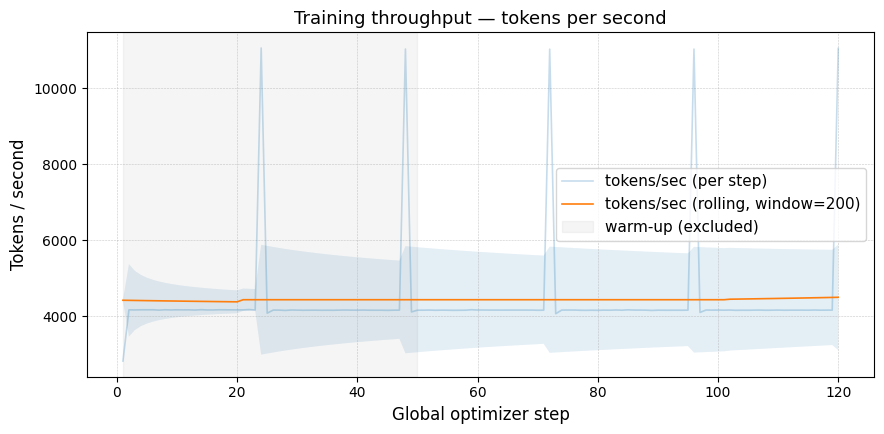

/tmp/ipython-input-2868102849.py:103: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  epochs = df["epoch"].fillna(method="ffill").unique()


Saved figure: ./figures/samples_per_sec_over_steps.png


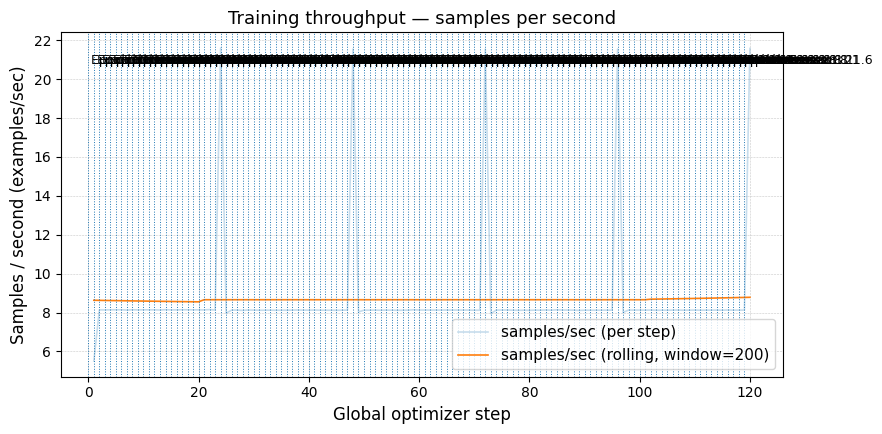

Summary statistics saved.


In [ ]:
# Academic-style plotting for throughput_log.csv (from TimingCallback)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === User parameters ===
CSV_PATH = "throughput_log.csv"         # path you passed to TimingCallback
OUT_DIR = "./figures"
os.makedirs(OUT_DIR, exist_ok=True)

WARMUP_STEPS = 50       # number of initial optimizer steps to exclude as warm-up (tune as needed)
ROLL_WINDOW = 200       # rolling window (in steps) for smoothing; adjust to your log length
SAVE_DPI = 300

# === Read CSV ===
df = pd.read_csv(CSV_PATH)

# Ensure expected numeric columns
for c in ["step_time_s", "samples_per_step", "tokens_per_step", "global_step"]:
    if c not in df.columns and c == "global_step":
        # some callbacks wrote "global_step", else use index
        df["global_step"] = df.index
        break

# convert types
df["step_time_s"] = pd.to_numeric(df["step_time_s"], errors="coerce")
df["samples_per_step"] = pd.to_numeric(df["samples_per_step"], errors="coerce")
df["tokens_per_step"] = pd.to_numeric(df["tokens_per_step"], errors="coerce")

# compute throughput metrics
df["samples_per_sec"] = df["samples_per_step"] / df["step_time_s"]
df["tokens_per_sec"] = df["tokens_per_step"] / df["step_time_s"]

# rolling stats
roll = lambda s: s.rolling(window=ROLL_WINDOW, min_periods=1, center=True).mean()
df["tokens_per_sec_roll"] = roll(df["tokens_per_sec"])
df["samples_per_sec_roll"] = roll(df["samples_per_sec"])
df["tokens_per_sec_std"] = df["tokens_per_sec"].rolling(window=ROLL_WINDOW, min_periods=1).std()

# steady-state selection (after warm-up)
steady = df.iloc[WARMUP_STEPS : ].copy()
if steady.empty:
    steady = df.copy()

# summary statistics (steady-state)
summary = {
    "tokens_per_sec_mean": steady["tokens_per_sec"].mean(),
    "tokens_per_sec_median": steady["tokens_per_sec"].median(),
    "tokens_per_sec_p5": steady["tokens_per_sec"].quantile(0.05),
    "tokens_per_sec_p95": steady["tokens_per_sec"].quantile(0.95),
    "samples_per_sec_mean": steady["samples_per_sec"].mean(),
    "samples_per_sec_median": steady["samples_per_sec"].median()
}
print("Steady-state throughput summary (after warm-up):")
for k,v in summary.items():
    print(f"  {k}: {v:.2f}")

# === Plot settings for academic style ===
plt.rcParams.update({
    "figure.figsize": (9,4.5),
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "savefig.dpi": SAVE_DPI,
    "lines.linewidth": 1.2
})

# ---- Figure 1: Tokens/sec over steps (with rolling avg + variability) ----
fig, ax = plt.subplots()
x = df["global_step"] if "global_step" in df.columns else df.index
ax.plot(x, df["tokens_per_sec"], alpha=0.25, label="tokens/sec (per step)")
ax.plot(x, df["tokens_per_sec_roll"], label=f"tokens/sec (rolling, window={ROLL_WINDOW})")
# shaded ±1 std of rolling window (if available)
std = df["tokens_per_sec_std"].fillna(0)
ax.fill_between(x, df["tokens_per_sec_roll"] - std, df["tokens_per_sec_roll"] + std, alpha=0.12)
# annotate warm-up region
if WARMUP_STEPS > 0:
    warmup_x = x.iloc[:WARMUP_STEPS]
    ax.axvspan(warmup_x.min(), warmup_x.max(), color='grey', alpha=0.08, label="warm-up (excluded)")

ax.set_xlabel("Global optimizer step")
ax.set_ylabel("Tokens / second")
ax.set_title("Training throughput — tokens per second")
ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
ax.legend()
plt.tight_layout()
fpath = os.path.join(OUT_DIR, "tokens_per_sec_over_steps.png")
plt.savefig(fpath, bbox_inches="tight")
print(f"Saved figure: {fpath}")
plt.show()

# ---- Figure 2: Samples/sec & per-epoch aggregation ----
fig, ax = plt.subplots()
ax.plot(x, df["samples_per_sec"], alpha=0.25, label="samples/sec (per step)")
ax.plot(x, df["samples_per_sec_roll"], label=f"samples/sec (rolling, window={ROLL_WINDOW})")

# If epoch column exists, draw vertical boundaries and annotate epoch averages
if "epoch" in df.columns:
    epochs = df["epoch"].fillna(method="ffill").unique()
    for e in epochs:
        # find first index of epoch e
        idxs = df.index[df["epoch"]==e].tolist()
        if not idxs:
            continue
        ax.axvline(x=idxs[0], linestyle=":", linewidth=0.7)
        # epoch mean
        e_mean = df.loc[df["epoch"]==e, "samples_per_sec"].mean()
        ax.text(idxs[0]+0.5, ax.get_ylim()[1]*0.95, f"Epoch {int(e)} mean: {e_mean:.1f}", fontsize=9, verticalalignment='top')

ax.set_xlabel("Global optimizer step")
ax.set_ylabel("Samples / second (examples/sec)")
ax.set_title("Training throughput — samples per second")
ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
ax.legend()
plt.tight_layout()
fpath = os.path.join(OUT_DIR, "samples_per_sec_over_steps.png")
plt.savefig(fpath, bbox_inches="tight")
print(f"Saved figure: {fpath}")
plt.show()

# ---- Optional: Small table of summary stats saved to CSV for the thesis ----
pd.Series(summary).to_csv(os.path.join(OUT_DIR, "throughput_summary_stats.csv"))
print("Summary statistics saved.")


##Visualizing LoRA Model

In [ ]:
import pandas as pd
import numpy as np

# Data from the mbpp_adapter
data = {
    "Epoch": [1, 2, 3, 4, 5],
    "Training Loss": [2.341400, 2.157700, 1.956200, 1.832300, 1.803000],
    "Validation Loss": [2.353944, 2.135633, 2.006576, 1.915481, 1.880655],
    "Bleu": [0.193154, 0.194993, 0.202520, 0.201009, 0.200844],
    "RougeL": [0.533877, 0.536636, 0.555202, 0.553825, 0.553992],
    "Exact Match": [0.0, 0.0, 0.0, 0.0, 0.0],
    "Avg Edit Distance": [1043.011111, 1047.111111, 1044.511111, 1045.600000, 1046.400000],
    "Entropy": [4.754701, 4.759662, 4.767116, 4.765970, 4.765502],
    "Num Tokens": [191488, 382976, 574464, 765952, 957440],
    "Mean Token Accuracy": [0.639754, 0.650686, 0.666477, 0.667128, 0.667628],
}


df = pd.DataFrame(data)

# Display nicely
pd.set_option("display.precision", 6)
print(df)

# Save to CSV for use in plotting / thesis figures
df.to_csv("training_metrics_table.csv", index=False)
print("\nSaved CSV -> training_metrics_table.csv")


   Epoch  Training Loss  Validation Loss      Bleu    RougeL  Exact Match  \
0      1         2.3414         2.353944  0.193154  0.533877          0.0   
1      2         2.1577         2.135633  0.194993  0.536636          0.0   
2      3         1.9562         2.006576  0.202520  0.555202          0.0   
3      4         1.8323         1.915481  0.201009  0.553825          0.0   
4      5         1.8030         1.880655  0.200844  0.553992          0.0   

   Avg Edit Distance   Entropy  Num Tokens  Mean Token Accuracy  
0        1043.011111  4.754701      191488             0.639754  
1        1047.111111  4.759662      382976             0.650686  
2        1044.511111  4.767116      574464             0.666477  
3        1045.600000  4.765970      765952             0.667128  
4        1046.400000  4.765502      957440             0.667628  

Saved CSV -> training_metrics_table.csv


### Evaluation Metrics – BLEU, ROUGE-L, Exact Match
hows model generation quality improving (or stabilizing) across epochs. These are standard text generation metrics.

In [ ]:
# File: analysis_plots For GPT-2 LoRA on MBPP and Codealpaca Adapters.py

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid", context="paper", font_scale=1.1)

df = pd.DataFrame(data)

In [ ]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="Epoch", y="BLEU", marker="o", label="BLEU")
sns.lineplot(data=df, x="Epoch", y="ROUGE-L", marker="o", label="ROUGE-L")
sns.lineplot(data=df, x="Epoch", y="Exact Match", marker="o", label="Exact Match")

plt.title("Evaluation Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

OUTDIR = "figures"
os.makedirs(OUTDIR, exist_ok=True)

# === Data from your table ===
Data = pd.DataFrame({
    "Epoch":           [1, 2, 3, 4, 5],
    "Training Loss":   [2.341400, 2.157700, 1.956200, 1.832300, 1.803000],
    "Validation Loss": [2.353944, 2.135633, 2.006576, 1.915148, 1.880655],
    "Bleu":            [0.193154, 0.194993, 0.202520, 0.201009, 0.200844],
    "ROUGE-L":         [0.533877, 0.536636, 0.555202, 0.553825, 0.553992],
    "Exact Match":     [0.0, 0.0, 0.0, 0.0, 0.0],       # constant zero - not informative
    "Avg Edit Distance":[1043.011111, 1047.111111, 1044.511111, 1045.600000, 1046.400000],
    "Entropy":         [4.754701, 4.759662, 4.767116, 4.765970, 4.765502],
    "Num Tokens":      [191488.0, 382976.0, 574464.0, 765952.0, 957440.0],
    "Mean Token Accuracy":[0.639754, 0.650686, 0.666477, 0.667128, 0.667628],
})


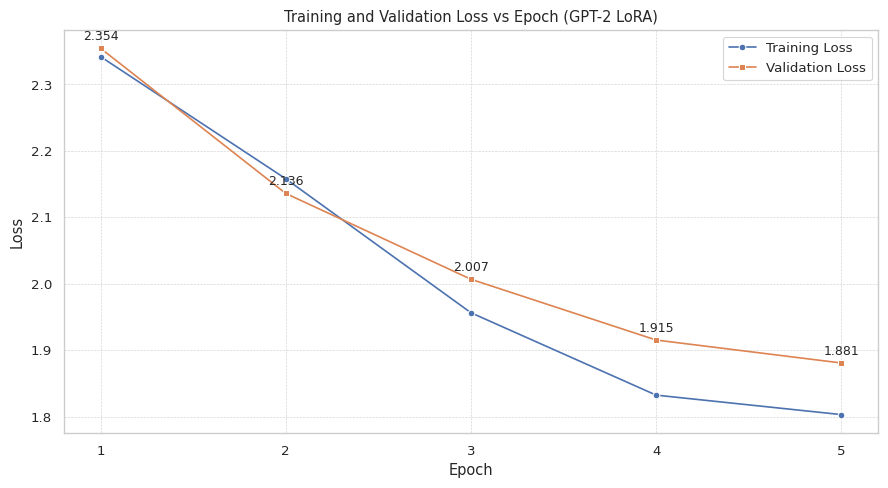

In [ ]:
# Training & Validation Loss vs Epoch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(context="paper", style="whitegrid", font_scale=1.1)

# Use previously defined Data
# Columns used: Epoch, Training Loss, Validation Loss
plt.figure(figsize=(9,5))
ax = sns.lineplot(data=Data, x="Epoch", y="Training Loss", marker="o", label="Training Loss")
sns.lineplot(data=Data, x="Epoch", y="Validation Loss", marker="s", label="Validation Loss", ax=ax)

# Annotate values above validation loss points
for x, y in zip(Data["Epoch"], Data["Validation Loss"]):
    ax.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=9)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(Data["Epoch"])
ax.set_title("Training and Validation Loss vs Epoch (GPT-2 LoRA)")
ax.grid(True, linestyle="--", linewidth=0.45, alpha=0.9)
plt.tight_layout()
plt.savefig("loss_vs_epoch.png", dpi=300)
plt.show()


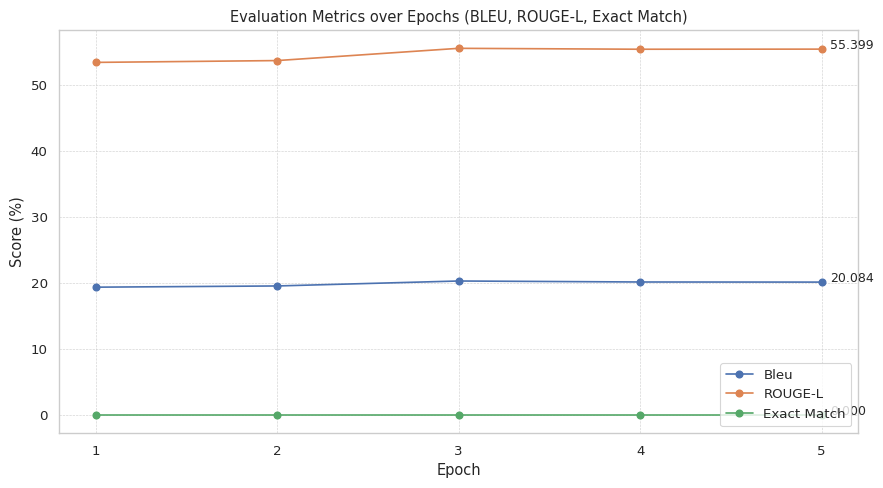

In [ ]:
# Evaluation Metrics (BLEU, ROUGE-L, Exact Match)
import matplotlib.ticker as ticker
plt.figure(figsize=(9,5))

# Columns to plot: BLEU, ROUGE-L, Exact Match
metrics_to_plot = ["Bleu", "ROUGE-L", "Exact Match"]

# Plot each metric
for metric in metrics_to_plot:
    plt.plot(Data["Epoch"], Data[metric]*100 if metric!="Exact Match" else Data[metric],
             marker="o", label=metric)

# Annotate last point of each metric
for metric in metrics_to_plot:
    x_last = Data["Epoch"].iloc[-1]
    y_last = Data[metric].iloc[-1]*100 if metric!="Exact Match" else Data[metric].iloc[-1]
    plt.annotate(f"{y_last:.3f}", (x_last, y_last), textcoords="offset points", xytext=(6,0), ha='left', fontsize=9)

plt.xlabel("Epoch")
plt.ylabel("Score (%)")
plt.title("Evaluation Metrics over Epochs (BLEU, ROUGE-L, Exact Match)")
plt.xticks(Data["Epoch"])
plt.grid(True, linestyle="--", linewidth=0.45, alpha=0.9)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("eval_metrics_over_epochs.png", dpi=300)
plt.show()


In [ ]:
df

,Epoch,Training Loss,Validation Loss,Bleu,RougeL,Exact Match,Avg Edit Distance,Entropy,Num Tokens,Mean Token Accuracy
0,1,2.3414,2.353944,0.193154,0.533877,0.0,1043.011111,4.754701,191488,0.639754
1,2,2.1577,2.135633,0.194993,0.536636,0.0,1047.111111,4.759662,382976,0.650686
2,3,1.9562,2.006576,0.202520,0.555202,0.0,1044.511111,4.767116,574464,0.666477
3,4,1.8323,1.915481,0.201009,0.553825,0.0,1045.600000,4.765970,765952,0.667128
4,5,1.8030,1.880655,0.200844,0.553992,0.0,1046.400000,4.765502,957440,0.667628


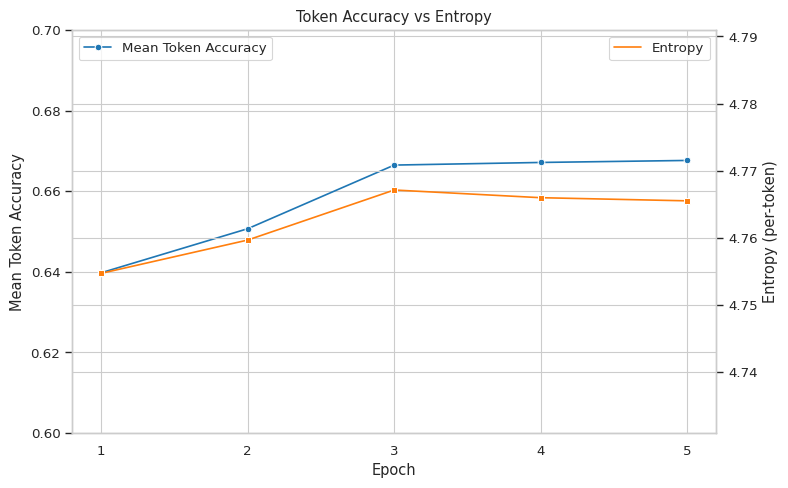

In [ ]:
# ===================================================================
# Plot : Mean Token Accuracy (left) & Entropy (right) vs epoch (twin axis)
# ===================================================================
plt.figure(figsize=(8,5))
ax1 = plt.gca()
ax2 = ax1.twinx()
sns.lineplot(x="Epoch", y="Mean Token Accuracy", data=df, marker="o", color="tab:blue", label="Mean Token Accuracy", ax=ax1)
sns.lineplot(x="Epoch", y="Entropy", data=df, marker="s", color="tab:orange", label="Entropy", ax=ax2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean Token Accuracy")
ax2.set_ylabel("Entropy (per-token)")
ax1.set_xticks(df["Epoch"])
ax1.set_ylim(0.60, 0.70)
ax2.set_ylim(df['Entropy'].min()*0.995, df['Entropy'].max()*1.005)
ax1.set_title("Token Accuracy vs Entropy")
ax1.legend(loc="upper left")
ax2.legend([plt.Line2D([0],[0], color='tab:orange')], ["Entropy"], loc="upper right")
plt.tight_layout()
plt.savefig("token_acc_entropy.png", dpi=300)
plt.show()

##Visualizing LoRA Model with MBPP Adapters

In [ ]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4, 5]
train_loss = [3.0928, 2.9043, 2.5556, 2.4169, 2.4171]
val_loss   = [2.8876, 2.6947, 2.5502, 2.4668, 2.4399]
bleu       = [0.1255, 0.1192, 0.1156, 0.1129, 0.1115]
rougeL     = [0.4431, 0.4469, 0.4680, 0.4768, 0.4793]
accuracy   = [0.5760, 0.5791, 0.5871, 0.5900, 0.5914]
entropy    = [4.2323, 4.3061, 4.3552, 4.3781, 4.3863]

# === 1. Training and Validation Loss ===
plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("loss_over_epochs.pdf", dpi=300)   # save as PDF
plt.savefig("loss_over_epochs.png", dpi=300)   # optional PNG
#plt.close()

# === 2. BLEU Score ===
plt.figure(figsize=(6,4))
plt.plot(epochs, bleu, marker='o', color='C2')
plt.xlabel("Epochs"); plt.ylabel("BLEU Score")
plt.title("BLEU Score Over Epochs")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("bleu_over_epochs.pdf", dpi=300)
plt.savefig("bleu_over_epochs.png", dpi=300)
#plt.close()

# === 3. ROUGE-L Score ===
plt.figure(figsize=(6,4))
plt.plot(epochs, rougeL, marker='o', color='C3')
plt.xlabel("Epochs"); plt.ylabel("ROUGE-L Score")
plt.title("ROUGE-L Score Over Epochs")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("rougeL_over_epochs.pdf", dpi=300)
plt.savefig("rougeL_over_epochs.png", dpi=300)
#plt.close()

# === 4. Token Accuracy ===
plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, marker='o', color='C4')
plt.xlabel("Epochs"); plt.ylabel("Mean Token Accuracy")
plt.title("Token Prediction Accuracy Over Epochs")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("accuracy_over_epochs.pdf", dpi=300)
plt.savefig("accuracy_over_epochs.png", dpi=300)
#plt.close()

# === 5. Entropy ===
plt.figure(figsize=(6,4))
plt.plot(epochs, entropy, marker='o', color='C5')
plt.xlabel("Epochs"); plt.ylabel("Entropy")
plt.title("Entropy of Predictions Over Epochs")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("entropy_over_epochs.pdf", dpi=300)
plt.savefig("entropy_over_epochs.png", dpi=300)
#plt.close()


In [ ]:
from google.colab import files
files.download("loss_over_epochs.pdf")
files.download("rougeL_over_epochs.pdf")
files.download("bleu_over_epochs.pdf")
files.download("accuracy_over_epochs.pdf")
files.download("entropy_over_epochs.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Training and Validation Loss Over Epochs

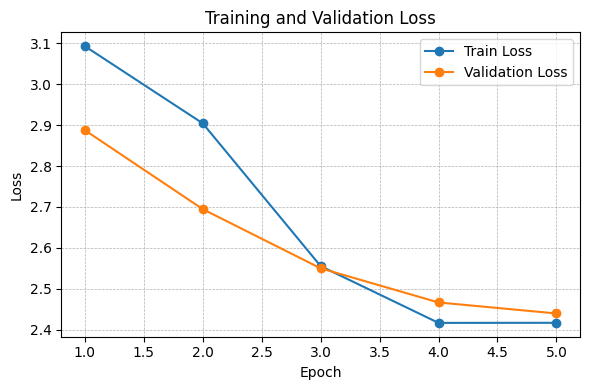

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
epochs = [1, 2, 3, 4, 5]
train_loss = [3.0928, 2.9043, 2.5556, 2.4169, 2.4171]
val_loss   = [2.8876, 2.6947, 2.5502, 2.4668, 2.4399]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, marker='o', color='C0', label='Train Loss')
plt.plot(epochs, val_loss,   marker='o', color='C1', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


###BLEU Score Over Epochs

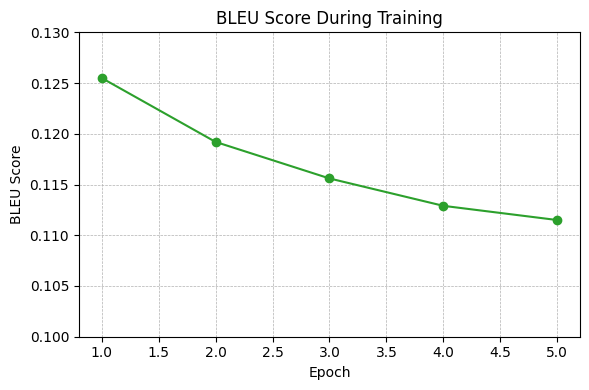

In [ ]:
# Plot BLEU score curve
bleu = [0.1255, 0.1192, 0.1156, 0.1129, 0.1115]  # from epochs 1–5

plt.figure(figsize=(6,4))
plt.plot(epochs, bleu, marker='o', color='C2')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.ylim(0.10, 0.13)
plt.title('BLEU Score During Training')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


###ROUGE-L Score Over Epochs

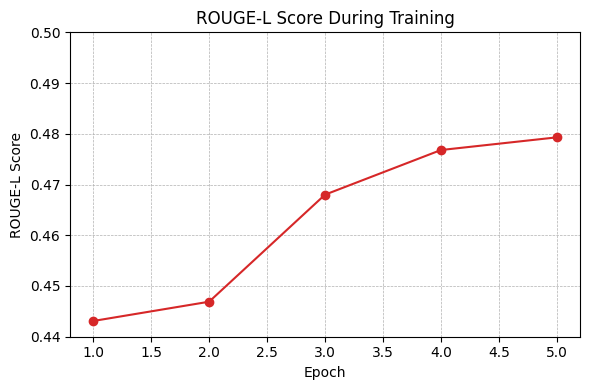

In [ ]:
# Plot ROUGE-L score curve
rouge = [0.4431, 0.4469, 0.4680, 0.4768, 0.4793]  # from epochs 1–5

plt.figure(figsize=(6,4))
plt.plot(epochs, rouge, marker='o', color='C3')
plt.xlabel('Epoch')
plt.ylabel('ROUGE-L Score')
plt.ylim(0.44, 0.50)
plt.title('ROUGE-L Score During Training')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


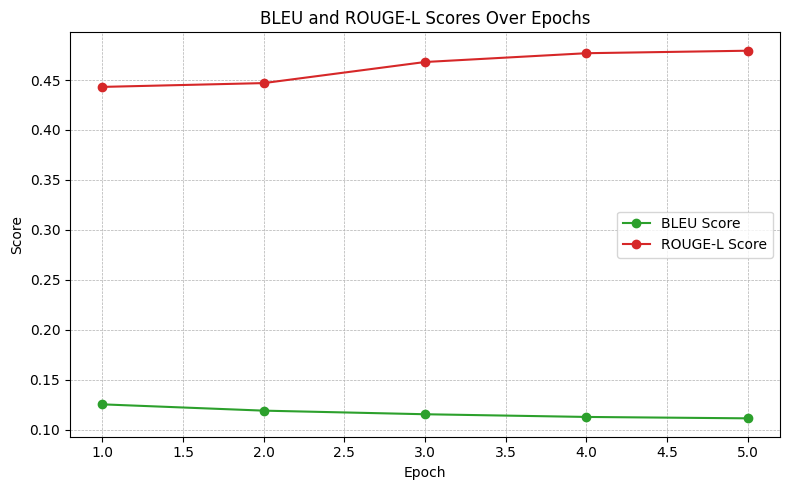

In [ ]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4, 5]
bleu = [0.1255, 0.1192, 0.1156, 0.1129, 0.1115]  # from epochs 1–5
rouge = [0.4431, 0.4469, 0.4680, 0.4768, 0.4793]  # from epochs 1–5

plt.figure(figsize=(8, 5)) # Increased figure size for better readability

# Plot BLEU score
plt.plot(epochs, bleu, marker='o', color='C2', label='BLEU Score')

# Plot ROUGE-L score
plt.plot(epochs, rouge, marker='o', color='C3', label='ROUGE-L Score')

plt.xlabel('Epoch')
plt.ylabel('Score')
# Set a title that reflects both metrics
plt.title('BLEU and ROUGE-L Scores Over Epochs')
plt.legend() # Add a legend to distinguish the lines
plt.grid(True, linestyle='--', linewidth=0.5) # Add a grid
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

###Mean Token Accuracy Over Epochs

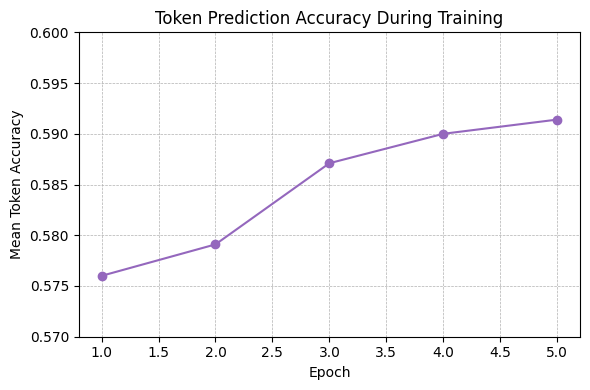

In [ ]:
# Plot mean token accuracy curve
acc = [0.5760, 0.5791, 0.5871, 0.5900, 0.5914]  # from epochs 1–5

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, marker='o', color='C4')
plt.xlabel('Epoch')
plt.ylabel('Mean Token Accuracy')
plt.ylim(0.57, 0.60)
plt.title('Token Prediction Accuracy During Training')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


###Entropy of Model Predictions Over Epochs

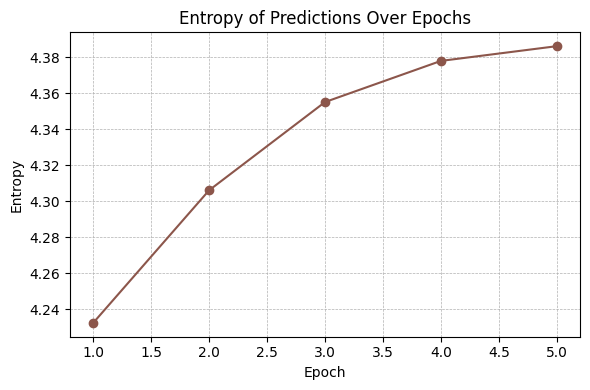

In [ ]:
# Plot prediction entropy curve
entropy = [4.2323, 4.3061, 4.3552, 4.3781, 4.3863]  # from epochs 1–5

plt.figure(figsize=(6,4))
plt.plot(epochs, entropy, marker='o', color='C5')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy of Predictions Over Epochs')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Trainable Parameter Count: Full Model vs LoRA Adapter

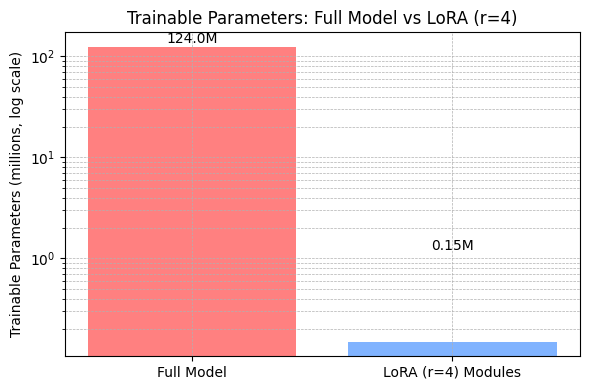

In [ ]:
# Bar chart of trainable parameters (example values)
import numpy as np

params = {'Full Model': 124.0,    # e.g., 124M total parameters
          'LoRA (r=4) Modules': 0.15}  # e.g., ~0.15M from LoRA layers
labels = list(params.keys())
vals   = list(params.values())

plt.figure(figsize=(6,4))
bars = plt.bar(labels, vals, color=['#ff8080','#80b3ff'])
plt.yscale('log')
plt.ylabel('Trainable Parameters (millions, log scale)')
plt.title('Trainable Parameters: Full Model vs LoRA (r=4)')
# Annotate absolute values
plt.text(0, vals[0]*1.1, f"{vals[0]:.1f}M", ha='center')
plt.text(1, vals[1]*8,    f"{vals[1]:.2f}M", ha='center')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


##Inference for NLG

In [ ]:
# Load the tokenizer and model
tokenizergpt2 = GPT2Tokenizer.from_pretrained("gpt2")
# Load the tokenizer and model
modelgpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
base_tokenizer=tokenizergpt2
base_model= modelgpt2

In [ ]:
model= lora_model

In [ ]:
# Prompt
#prompt = "Once upon a time"
prompt= "Write a Python function to check if a number is prime."

# Tokenize the input text
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[16594,   257, 11361,  2163,   284,  2198,   611,   257,  1271,   318,
          6994,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
# Generate text
output_ids = model.generate(
    inputs.input_ids.to(model.device),
    attention_mask=inputs.attention_mask.to(model.device),
    pad_token_id=tokenizer.eos_token_id,
    max_length=50,
    num_return_sequences=1
)

output_ids

tensor([[16594,   257, 11361,  2163,   284,  2198,   611,   257,  1271,   318,
          6994,    13,   198,  4299,   318,    62, 35505,     7,    77,  2599,
          1441,   299,  4064,   362,  6624,   657,   198,  4299,   318,    62,
         35505,    62,    77,     7,    77,  2599,  1441,   299,  4064,   362,
          6624,   299,   198,  4299,   318,    62, 35505,    62,    77,    62]],
       device='cuda:0')

In [ ]:
# Decode the generated text
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(generated_text)

Write a Python function to check if a number is prime.
def is_prime(n): return n % 2 == 0
def is_prime_n(n): return n % 2 == n
def is_prime_n_
